In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import boto3
import io
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Waves

In [2]:
# ───────────── Settings ─────────────
BUCKET       = 'bdc-public-curated'
PREFIX       = 'ndacan/nytd/outcomes/waves_processed/'

# ───────────── Initialize S3 client & list files ─────────────
s3 = boto3.client('s3')

In [3]:
def s3_read_csv(key):
    """Load a CSV from S3 into a pandas DataFrame."""
    obj = s3.get_object(Bucket=BUCKET, Key=key)
    return pd.read_csv(io.BytesIO(obj['Body'].read()), dtype=str)

In [4]:
all_wave = s3_read_csv(f"{PREFIX}cleaned_all_waves.csv")

# All data: Afcars, service and waves

In [5]:
wave_service_afcars = pd.read_csv('nytd_final_modeling_data_20250724_090259(in).csv', dtype=str)

Used all wave dataset with _w1 and _w23 data calculated to replace _w1, _w2 and _w3

In [6]:
# Drop all columns that end with _w1, _w2, or _w3
wave_service_afcars = wave_service_afcars.drop(
    columns=[col for col in wave_service_afcars.columns if col.endswith(('_w1', '_w2', '_w3'))]
)

In [7]:
wave_service_afcars = all_wave.merge(wave_service_afcars, on='StFCID', how='left')

Check for correct merging

In [8]:
# Step 1: Get columns that came from the right side of the merge
right_only_cols = [col for col in wave_service_afcars.columns if col not in all_wave.columns or col == 'StFCID']

# Step 2: Identify rows where all right-side columns are NaN
unmatched_rows = wave_service_afcars[right_only_cols].isna().all(axis=1)

# Step 3: View or count them
num_unmatched = unmatched_rows.sum()
print(f"❗ Number of rows where wave_service_afcars data did not match (all NaNs): {num_unmatched}")

#see shape and size
print(wave_service_afcars.shape)

❗ Number of rows where wave_service_afcars data did not match (all NaNs): 0
(720, 96)


** StFIPS and Sex are bc one is a decimal and one is not **

In [9]:
# Function to strip common suffixes
def strip_suffix(col_name):
    return re.sub(r'(_x|_y)$', '', col_name)

# Group columns by base name
base_name_map = defaultdict(list)
for col in wave_service_afcars.columns:
    base = strip_suffix(col)
    base_name_map[base].append(col)

# Check which groups have identical values across all their versions
same_value_columns = {}

for base, cols in base_name_map.items():
    if len(cols) > 1:
        first_col = wave_service_afcars[cols[0]]
        identical = all(wave_service_afcars[c].equals(first_col) for c in cols[1:])
        same_value_columns[base] = identical

# Show only those that have identical values across versions
for base, is_identical in same_value_columns.items():
    if is_identical:
        print(f"✅ Columns with base '{base}' have identical values across all versions: {base_name_map[base]}")
    else:
        print(f"❌ Columns with base '{base}' have DIFFERENT values across: {base_name_map[base]}")


❌ Columns with base 'StFIPS' have DIFFERENT values across: ['StFIPS_x', 'StFIPS_y']
✅ Columns with base 'St' have identical values across all versions: ['St_x', 'St_y']
❌ Columns with base 'Sex' have DIFFERENT values across: ['Sex_x', 'Sex_y']
✅ Columns with base 'Cohort' have identical values across all versions: ['Cohort_x', 'Cohort_y']


Check all of csv for different matching  base-name column values

In [10]:
for base, cols in base_name_map.items():
    if len(cols) == 2 and not wave_service_afcars[cols[0]].equals(wave_service_afcars[cols[1]]):
        print(f"\n❌ Differences in {base}:")
        diffs = wave_service_afcars[
            ~wave_service_afcars[cols[0]].eq(wave_service_afcars[cols[1]]) & 
            ~(wave_service_afcars[cols[0]].isna() & wave_service_afcars[cols[1]].isna())
        ][cols]
        print(diffs)



❌ Differences in StFIPS:
    StFIPS_x StFIPS_y
0       47.0       47
1       47.0       47
2       47.0       47
3       47.0       47
4       47.0       47
..       ...      ...
309     47.0       47
310     47.0       47
311     47.0       47
312     47.0       47
313     47.0       47

[314 rows x 2 columns]

❌ Differences in Sex:
    Sex_x Sex_y
0     2.0     2
1     2.0     2
2     1.0     1
3     2.0     2
4     2.0     2
..    ...   ...
715   1.0     1
716   2.0     2
717   2.0     2
718   1.0     1
719   1.0     1

[720 rows x 2 columns]


In [11]:
wave_service_afcars = wave_service_afcars.rename(columns ={'Cohort_y' : 'Cohort', 'St_y' : 'St', 'StFIPS_y' : 'StFIPS', 'Sex_y' : 'Sex'})
wave_service_afcars = wave_service_afcars.drop(columns={'OutcmDte_w1', 'Cohort_x', 'St_x','StFIPS_x', 'Sex_x','RepDate_w1', 'RepDate_w23', 'Race_w1','OutcmDte_w23', 'StFIPS', 'HighEdCert_w1', 'HighEdCert_w23'})

In [12]:
wave_service_afcars.to_csv('wave_service_afcars.csv', index=False)

In [13]:
wave_service_afcars =pd.read_csv('wave_service_afcars.csv', dtype=str)

# Dictionaries 

##### Dependent (education & employment)

In [14]:
# Post secondary education
higher_education_columns = [
    'CurrenRoll_w1',
    'CurrenRoll_w23',
    'Voc_Certificate_w1',
    'Voc_Certificate_w23',
    'Voc_License_w1',
    'Voc_License_w23',
    'Assoc_Degree_w1',
    'Assoc_Degree_w23',
    'Bach_Degree_w1',
    'Bach_Degree_w23',
    'Higher_Degree_w1',
    'Higher_Degree_w23'
]

# Full time employment
full_time_employment_columns = [
    'CurrFTE_w1',
    'CurrFTE_w23'
]

# Full time employment and post secondary education
Emplyment_or_post_secondary = [ 
    'CurrenRoll_w1',
    'CurrenRoll_w23',
    'Voc_Certificate_w1',
    'Voc_Certificate_w23',
    'Voc_License_w1',
    'Voc_License_w23',
    'Assoc_Degree_w1',
    'Assoc_Degree_w23',
    'Bach_Degree_w1',
    'Bach_Degree_w23',
    'Higher_Degree_w1',
    'Higher_Degree_w23',
    'CurrFTE_w1',
    'CurrFTE_w23'
]

#### Independent

 Homelessness

In [15]:
# Late Homelessness
Homeless_wave_23 = ['Homeless_w23']
# Early Homelessness
Homeless = ['Homeless_w1', 'Homeless_w23']

Male = 0
Female = 1

In [16]:
wave_service_afcars['Sex'] = wave_service_afcars['Sex'].map({'1': 0, '2': 1}).astype('object')

# Descriptive Stats

In [17]:
# Generate descriptive stats
descriptive_stats = wave_service_afcars.describe(include='all').T

# Add a column for the column name
descriptive_stats = descriptive_stats.reset_index().rename(columns={'index': 'column_name'})

# Optional: display or save
print(descriptive_stats.head())

   column_name count unique             top freq
0       StFCID   720    720  TNµ®œ¿ˆ©¬«÷½û¥    1
1  OutcmRpt_w1   720      1               1  720
2  OutcmFCS_w1   720      1             1.0  720
3   CurrFTE_w1   710      2             0.0  702
4   CurrPTE_w1   711      2             0.0  640


In [18]:
descriptive_stats.to_csv('descriptive_stats.csv', index=False)

# Multi model

In [19]:
wave_service_afcars['Children_w23'] = pd.to_numeric(wave_service_afcars['Children_w23'], errors='coerce').astype('Int64')
wave_service_afcars['Marriage_w23'] = pd.to_numeric(wave_service_afcars['Marriage_w23'], errors='coerce').astype('Int64')


In [20]:
wave_service_afcars['Children_NoMarriage_w23'] = (
    (wave_service_afcars['Children_w23'] == 1) & 
    (wave_service_afcars['Marriage_w23'] == 0)
).astype('Int64')



In [21]:
wave_service_afcars['AI_AN_Only'] = pd.to_numeric(wave_service_afcars['AI_AN_Only'], errors='coerce').astype('Int64')
wave_service_afcars['Asian_Only'] = pd.to_numeric(wave_service_afcars['Asian_Only'], errors='coerce').astype('Int64')
wave_service_afcars['PacIsl_Only'] = pd.to_numeric(wave_service_afcars['PacIsl_Only'], errors='coerce').astype('Int64')
wave_service_afcars['Multi_Race'] = pd.to_numeric(wave_service_afcars['Multi_Race'], errors='coerce').astype('Int64')

In [22]:
wave_service_afcars['race_other'] = (
    (wave_service_afcars[['AI_AN_Only', 'Asian_Only', 'PacIsl_Only', 'Multi_Race']] == 1)
    .any(axis=1)
).astype(int)

In [23]:
wave_service_afcars['CurrFTE_w23'] = pd.to_numeric(wave_service_afcars['CurrFTE_w23'], errors='coerce').astype('Int64')
wave_service_afcars['CurrenRoll_w23'] = pd.to_numeric(wave_service_afcars['CurrenRoll_w23'], errors='coerce').astype('Int64')

In [24]:
wave_service_afcars['Connected_Youth'] = (
    (wave_service_afcars['CurrFTE_w23'] == 1) | 
    (wave_service_afcars['CurrenRoll_w23'] == 1)
).astype('Int64')

In [25]:
wave_service_afcars['PlacementType'] = pd.to_numeric(wave_service_afcars['PlacementType'], errors='coerce').astype('Int64')

In [30]:
outcomes = [
    'Connected_Youth',
    'CnctAdult_w23',
    'Homeless_w23',
    'SubAbuse_w23',
    'Incarc_w23',
    'Children_NoMarriage_w23'

]

predictor_groups = {
    'Core': ['Sex'] + ['White_Only', 'race_other'],
    'Disability': ['DiagDis'],
    'RemovalReason': ['RR_neglect', 'RR_abuse', 'RR_other'],
    'PlacementOther': ['PlacementType', 'PlacementInstability', 'MonthsInCare'],
    'EarlyIndicators': ['SubAbuse_w1', 'CnctAdult_w1']
}


In [28]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
all_results = []
significant_results = []

for outcome in outcomes:
    predictors = sum(predictor_groups.values(), [])  # flatten all predictor lists
    model_vars = predictors + [outcome]
    
    df_model = wave_service_afcars[model_vars].copy()
    df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()
    df_model = df_model.apply(pd.to_numeric, errors='coerce')
    # Step 1: Create dummies (drop_first=True avoids dummy trap)
    df_model = pd.get_dummies(df_model, columns=['PlacementType'], drop_first=True)

    # Step 2: Rename the resulting dummy columns
    df_model = df_model.rename(columns={
    'PlacementType_1.0': 'GroupHome',
    'PlacementType_2.0': 'FosterHome',
    'PlacementType_3.0': 'OtherPlacement'
})

    # Apply min-max scaling to PlacementType and MonthsinCare before one-hot encoding
    scaler = MinMaxScaler()
    
    # Scale PlacementInstability and MonthsinCare if they exist in the data
    columns_to_scale = ['PlacementInstability', 'MonthsinCare']
    existing_columns_to_scale = [col for col in columns_to_scale if col in df_model.columns]
    
    if existing_columns_to_scale:
        df_model[existing_columns_to_scale] = scaler.fit_transform(df_model[existing_columns_to_scale])
        print(f"Scaled columns: {existing_columns_to_scale}")
    # Prepare X and y
    y = df_model[outcome].astype(int)
    X = df_model.drop(columns=[outcome])
    X = sm.add_constant(X)
    
    try:
        # Fit logistic regression
        model = sm.Logit(y, X)
        result = model.fit(disp=False)
        
        # Extract full summary
        pvals = result.pvalues
        summary_df = pd.DataFrame({
            'Outcome': outcome,
            'Variable': pvals.index,
            'Coefficient': result.params,
            'P-Value': pvals,
            'CI Lower': result.conf_int()[0],
            'CI Upper': result.conf_int()[1]
        })
        
        # Mark significance
        summary_df['Significant'] = summary_df['P-Value'] < 0.05
        all_results.append(summary_df)
        
        # Store only significant rows
        sig_only = summary_df[summary_df['Significant'] == True]
        significant_results.append(sig_only)
        
        print(f"✅ Model completed for outcome: {outcome}")
        
    except Exception as e:
        print(f"❌ Model failed for outcome: {outcome} — {e}")

# Combine all results
if all_results:
    all_results_df = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal models run: {len(outcomes)}")
    print(f"Total significant predictors found: {sum(len(df) for df in significant_results)}")

if significant_results:
    significant_results_df = pd.concat(significant_results, ignore_index=True)
    print(f"\nSignificant results summary:")
    print(significant_results_df.groupby('Outcome')['Variable'].count().sort_values(ascending=False))

Scaled columns: ['PlacementInstability']
✅ Model completed for outcome: Connected_Youth
Scaled columns: ['PlacementInstability']
✅ Model completed for outcome: CnctAdult_w23
Scaled columns: ['PlacementInstability']
✅ Model completed for outcome: Homeless_w23
Scaled columns: ['PlacementInstability']
✅ Model completed for outcome: SubAbuse_w23
Scaled columns: ['PlacementInstability']
✅ Model completed for outcome: Incarc_w23
Scaled columns: ['PlacementInstability']
✅ Model completed for outcome: Children_NoMarriage_w23

Total models run: 6
Total significant predictors found: 19

Significant results summary:
Outcome
Incarc_w23                 5
Connected_Youth            4
SubAbuse_w23               4
Children_NoMarriage_w23    2
CnctAdult_w23              2
Homeless_w23               2
Name: Variable, dtype: int64


In [32]:
all_results_df['Variable'].unique()

array(['const', 'Sex', 'White_Only', 'race_other', 'DiagDis',
       'RR_neglect', 'RR_abuse', 'RR_other', 'PlacementInstability',
       'MonthsInCare', 'SubAbuse_w1', 'CnctAdult_w1', 'PlacementType_2',
       'PlacementType_3'], dtype=object)

In [33]:
# Combine results across all models
all_results_df = pd.concat(all_results, ignore_index=True)

In [34]:
# Show top significant results
print("📊 Top Significant Predictors (p < 0.05):")
display(all_results_df.head(10))



📊 Top Significant Predictors (p < 0.05):


,Outcome,Variable,Coefficient,P-Value,CI Lower,CI Upper,Significant
0,Connected_Youth,const,1.173625,0.095104,-0.204546,2.551795,False
1,Connected_Youth,Sex,0.518052,0.022106,0.074381,0.961723,True
2,Connected_Youth,White_Only,-0.027921,0.903517,-0.479367,0.423525,False
3,Connected_Youth,race_other,0.355022,0.570241,-0.870686,1.580729,False
4,Connected_Youth,DiagDis,-0.489774,0.022817,-0.911449,-0.068099,True
5,Connected_Youth,RR_neglect,0.120138,0.719546,-0.535636,0.775913,False
6,Connected_Youth,RR_abuse,0.238614,0.599982,-0.653168,1.130395,False
7,Connected_Youth,RR_other,-0.185765,0.681949,-1.074219,0.702689,False
8,Connected_Youth,PlacementInstability,-1.979549,0.008234,-3.447897,-0.511200,True
9,Connected_Youth,MonthsInCare,0.018982,0.031192,0.001715,0.036249,True


In [35]:
print(all_results_df.shape)


(84, 7)


In [36]:
significant_results_df = pd.concat(significant_results, ignore_index=True)

In [37]:
# Sort for readability (optional)
significant_results_df = significant_results_df.sort_values(by=['Outcome', 'P-Value'])


In [38]:
significant_results_df.head()

,Outcome,Variable,Coefficient,P-Value,CI Lower,CI Upper,Significant
17,Children_NoMarriage_w23,const,-2.408161,0.011350,-4.272450,-0.543871,True
18,Children_NoMarriage_w23,White_Only,-0.542520,0.026784,-1.022650,-0.062391,True
5,CnctAdult_w23,CnctAdult_w1,1.335801,0.032398,0.112072,2.559529,True
4,CnctAdult_w23,const,2.407237,0.047716,0.024224,4.790249,True
2,Connected_Youth,PlacementInstability,-1.979549,0.008234,-3.447897,-0.511200,True


In [39]:
print(significant_results_df.shape)


(19, 7)


In [41]:
# Save to CSV (optional)
all_results_df.to_csv("all_model_results.csv", index=False)
significant_results_df.to_csv("significant_model_results.csv", index=False)


# Significant Models & Data

In [42]:
significant_model_results = pd.read_csv("significant_model_results.csv")

In [43]:
# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [44]:
# Cell 2: Load and examine the significant results data
print("Significant Model Results Overview:")
print(f"Total significant effects: {len(significant_model_results)}")
print(f"Unique outcomes: {significant_model_results['Outcome'].nunique()}")
print(f"Outcomes: {significant_model_results['Outcome'].unique()}")
print(f"\nP-value range: {significant_model_results['P-Value'].min():.6f} to {significant_model_results['P-Value'].max():.6f}")
print(f"Coefficient range: {significant_model_results['Coefficient'].min():.3f} to {significant_model_results['Coefficient'].max():.3f}")


Significant Model Results Overview:
Total significant effects: 19
Unique outcomes: 6
Outcomes: ['Children_NoMarriage_w23' 'CnctAdult_w23' 'Connected_Youth'
 'Homeless_w23' 'Incarc_w23' 'SubAbuse_w23']

P-value range: 0.000004 to 0.047716
Coefficient range: -3.237 to 2.634


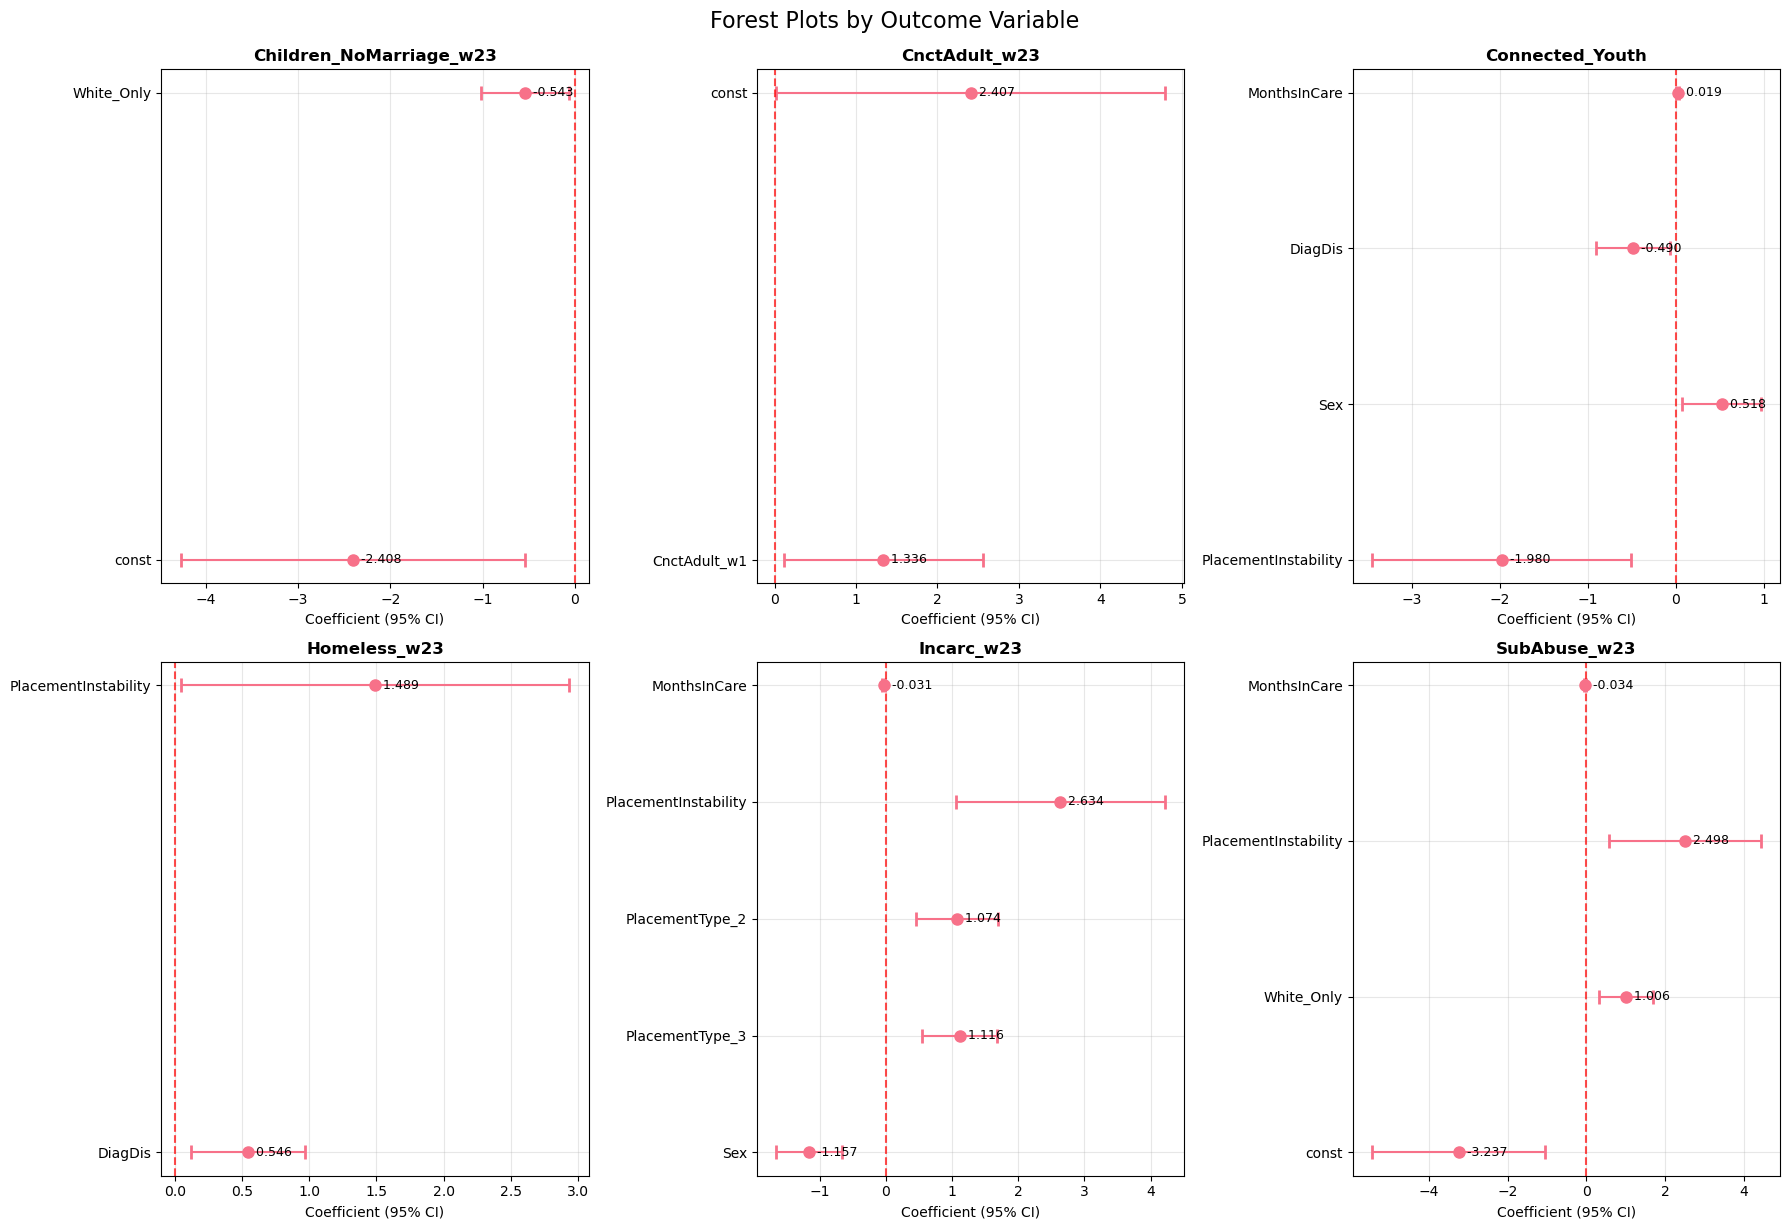

In [45]:
# Cell 3: Forest Plot by Outcome
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

outcomes = significant_model_results['Outcome'].unique()
for i, outcome in enumerate(outcomes):
    if i < len(axes):
        outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
        
        y_pos = range(len(outcome_data))
        coeffs = outcome_data['Coefficient']
        ci_lower = outcome_data['CI Lower']
        ci_upper = outcome_data['CI Upper']
        
        # Create error bars
        axes[i].errorbar(coeffs, y_pos,
                        xerr=[coeffs - ci_lower, ci_upper - coeffs],
                        fmt='o', capsize=5, capthick=2, markersize=8)
        
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(outcome_data['Variable'], fontsize=10)
        axes[i].set_xlabel('Coefficient (95% CI)')
        axes[i].set_title(f'{outcome}', fontsize=12, fontweight='bold')
        axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        axes[i].grid(True, alpha=0.3)
        
        # Add coefficient values as text
        for j, (coef, var) in enumerate(zip(coeffs, outcome_data['Variable'])):
            axes[i].text(coef, j, f'  {coef:.3f}', va='center', fontsize=9)

# Hide empty subplots
for i in range(len(outcomes), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Forest Plots by Outcome Variable', fontsize=16, y=1.02)
plt.show()

In [46]:
# See what unique values were in the original column
print("Unique values in PlacementType:")
print(wave_service_afcars['PlacementType'].unique())

# Or get value counts to see frequency too
print("\nValue counts:")
print(wave_service_afcars['PlacementType'].value_counts(dropna=False))

Unique values in PlacementType:
<IntegerArray>
[<NA>, 3, 2, 1]
Length: 4, dtype: Int64

Value counts:
<NA>    240
1       195
3       183
2       102
Name: PlacementType, dtype: Int64


 ### Visual Above:
 * Forest Plot: shows significant predictors for 6 outcomes
 **Top Left: Children without being married in wave 2/3**
 * **White_Only**: White youth are LESS likely (-0.543) to have children without being married
 * Larger negative intercept (-2.621) means there is a low probability of the outcome

 **Top Center: Connected adult in wave 2/3**
 * **Connected Adult in wave 1**: Having a strongly connected adult strongly predicts future outcomes (1.336)
 * **Constant**: There is a high baseline of adult connections (2.973)
 **Top Right: Connected Youth (pursuing a full-time job or higher education post-transition)**
 * **Months in care**: The longer the care duration, the more likely they are to have increased youth connections (0.019)
 * **Diagnosed with a disability**: Youth with a disability are less likely (-0.490) to be connected youth
 * **Sex**: One gender is more likely (0.518) to be connected
 * **PlacementInstability**: The more unstable the placement, the less likely they will be connected youth (-0.073)

 **Bottom Left: Homeless post-transition**
 * **PlacementInstability**: Unstable placement increases risk of homelessness (0.055)
 * **Diagnosed Disability**: A disability significantly increases risk of homelessness (0.546)

 **Bottom Center: Incarceration post-transition**
* **Sex**: Large gender difference in incarceration (-1.157)
 * **Months in care**: Longer time in care reduces incarceration (-0.031)
 * **PlacementInstability**: Unstable placement increases incarceration (0.098)
 * **Placement_Type_2**: Individuals in group homes are more likely to be incarcerated (1.074)
 * **Placement_Type_3**: Individuals in type 3 homes are more likely to be incarcerated (1.116)

 **Bottom Right: Substance abuse post-transition**
 * **White_Only**: White youth are more likely (1.006) to have substance abuse
 * **Months in care**: Longer time in care reduces substance abuse (-0.034)
 * **PlacementInstability**: More moves increase substance abuse (0.093)
* **Constant**: Overall low baseline probability (-3.516)

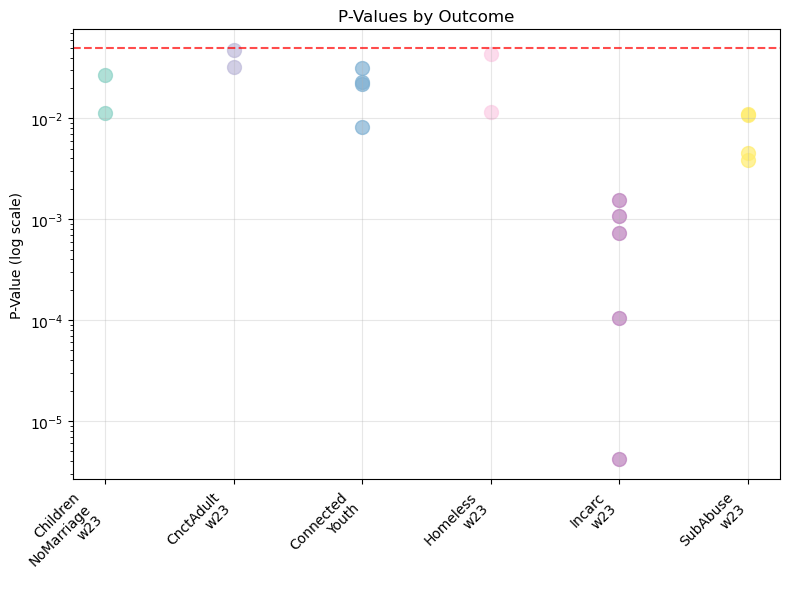

In [47]:
# P-value by outcome plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

outcomes_for_plot = significant_model_results['Outcome'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(outcomes_for_plot)))

for i, outcome in enumerate(outcomes_for_plot):
    outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
    ax.scatter([i] * len(outcome_data), outcome_data['P-Value'], 
               alpha=0.7, s=100, color=colors[i], label=outcome)

ax.set_yscale('log')
ax.set_xticks(range(len(outcomes_for_plot)))
ax.set_xticklabels([outcome.replace('_', '\n') for outcome in outcomes_for_plot], rotation=45, ha='right')
ax.set_ylabel('P-Value (log scale)')
ax.set_title('P-Values by Outcome')
ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α=0.05')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visual Above:
* **Incarc_w23** : Strongest, most predictable
* **SubAbuse_w23** : Multiple strong-moderate predictors
* **Rest**: Moderate

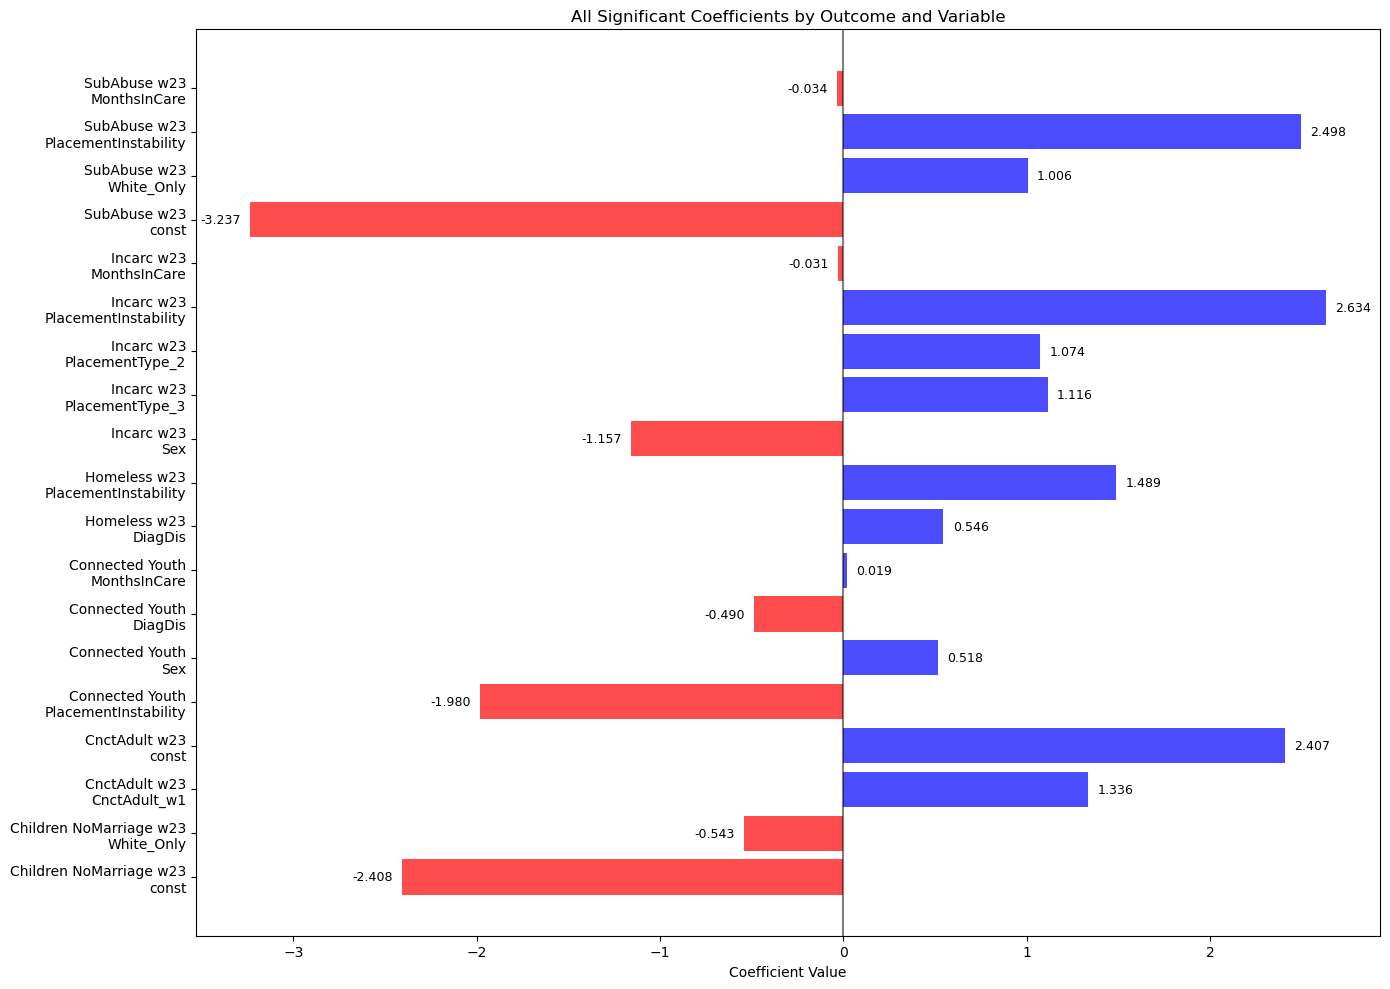

In [48]:
# Cell 5: Coefficient Magnitude Analysis
plt.figure(figsize=(14, 10))

# Create horizontal bar plot of all coefficients
y_pos = range(len(significant_model_results))
colors = ['red' if x < 0 else 'blue' for x in significant_model_results['Coefficient']]

plt.barh(y_pos, significant_model_results['Coefficient'], color=colors, alpha=0.7)

# Create labels with outcome and variable
labels = [f"{row['Outcome'].replace('_', ' ')}\n{row['Variable']}" 
          for _, row in significant_model_results.iterrows()]

plt.yticks(y_pos, labels, fontsize=10)
plt.xlabel('Coefficient Value')
plt.title('All Significant Coefficients by Outcome and Variable')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add coefficient values on bars
for i, (coef, outcome) in enumerate(zip(significant_model_results['Coefficient'], 
                                       significant_model_results['Outcome'])):
    offset = 0.05 if coef >= 0 else -0.05
    ha = 'left' if coef >= 0 else 'right'
    plt.text(coef + offset, i, f'{coef:.3f}', va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.show()

# Visual Above: 
* **Red bar**: Protective factors or risk reducers

**Substance Abuse wave 2/3**
* **Constant**: Low probabilty (-3.330)
* **MonthsInCare** (-0.034): Longer time in care is protective
* **PlacementInstability** (+0.093): More placement changes increase risk
* **White_Only** (+1.006): Being white-only increases substance abuse risk 

**Incarceration (Incarc_w23)**
* **Sex** (-1.157): Strong protective effect for females (or higher risk for males)
* **PlacementType_2 & 3** (+1.074, +1.116): Certain placement types significantly increase risk
* **PlacementInstability** (+0.098): Instability increases incarceration risk
* **MonthsInCare** (-0.031): Longer care duration is protective

**Adult Connections (CnctAdult_w23)**
* **Constant** (+2.401): High baseline probability
* **CnctAdult_w1** (+1.336): Early connections strongly predict later connections

**Connected Youth (Employment/Education)**
* **Sex** (+0.518): Females more likely to be connected
* **DiagDis** (-0.490): Diagnosed disabilities reduce connection likelihood
* **PlacementInstability** (-0.073): Instability reduces positive outcomes

**Children Without Marriage**
* **Constant** (-2.439): Low baseline probability
* **White_Only** (-0.543): Being white-only reduces likelihood

**Homelessness**
* **DiagDis** (+0.546): Disabilities increase homelessness risk
* **PlacementInstability** (+0.055): Instability increases risk


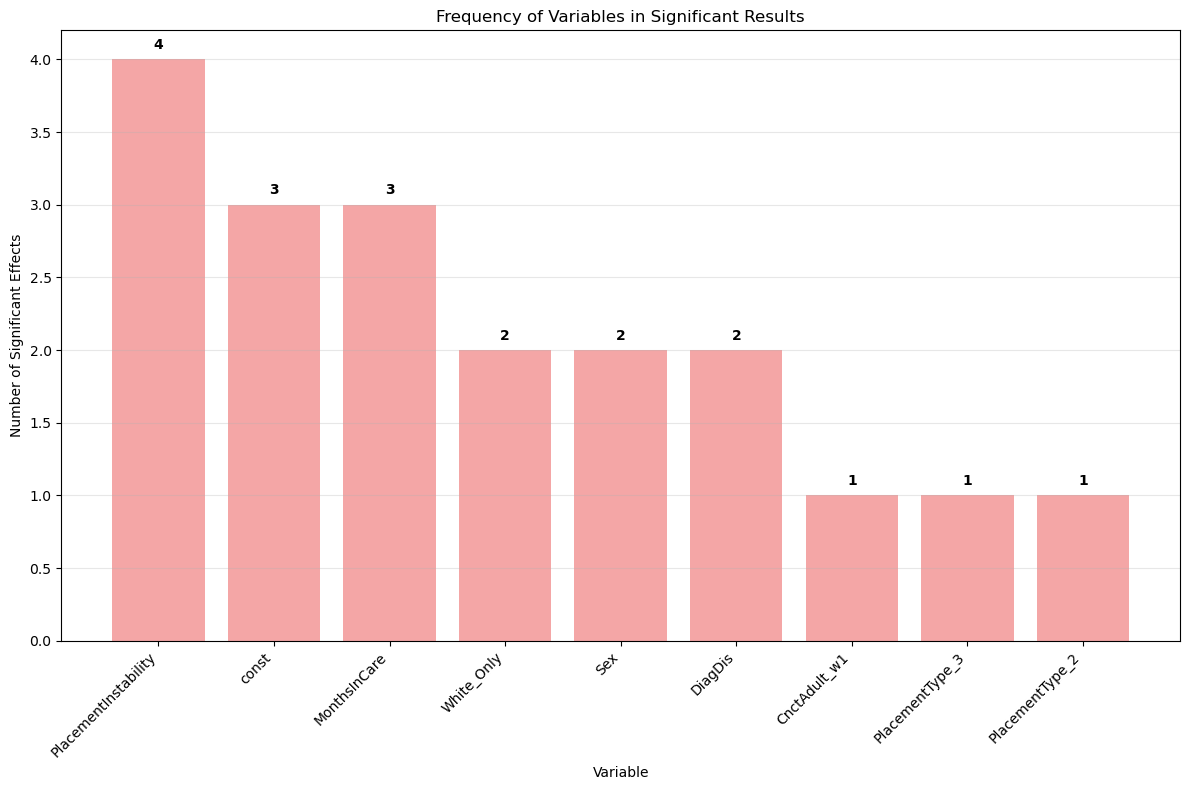

In [49]:
# Cell 6: Variable Frequency Analysis
plt.figure(figsize=(12, 8))

# Count how often each variable appears as significant
variable_counts = significant_model_results['Variable'].value_counts()

plt.bar(range(len(variable_counts)), variable_counts.values, alpha=0.7, color='lightcoral')
plt.xticks(range(len(variable_counts)), variable_counts.index, rotation=45, ha='right')
plt.ylabel('Number of Significant Effects')
plt.xlabel('Variable')
plt.title('Frequency of Variables in Significant Results')
plt.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, count in enumerate(variable_counts.values):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

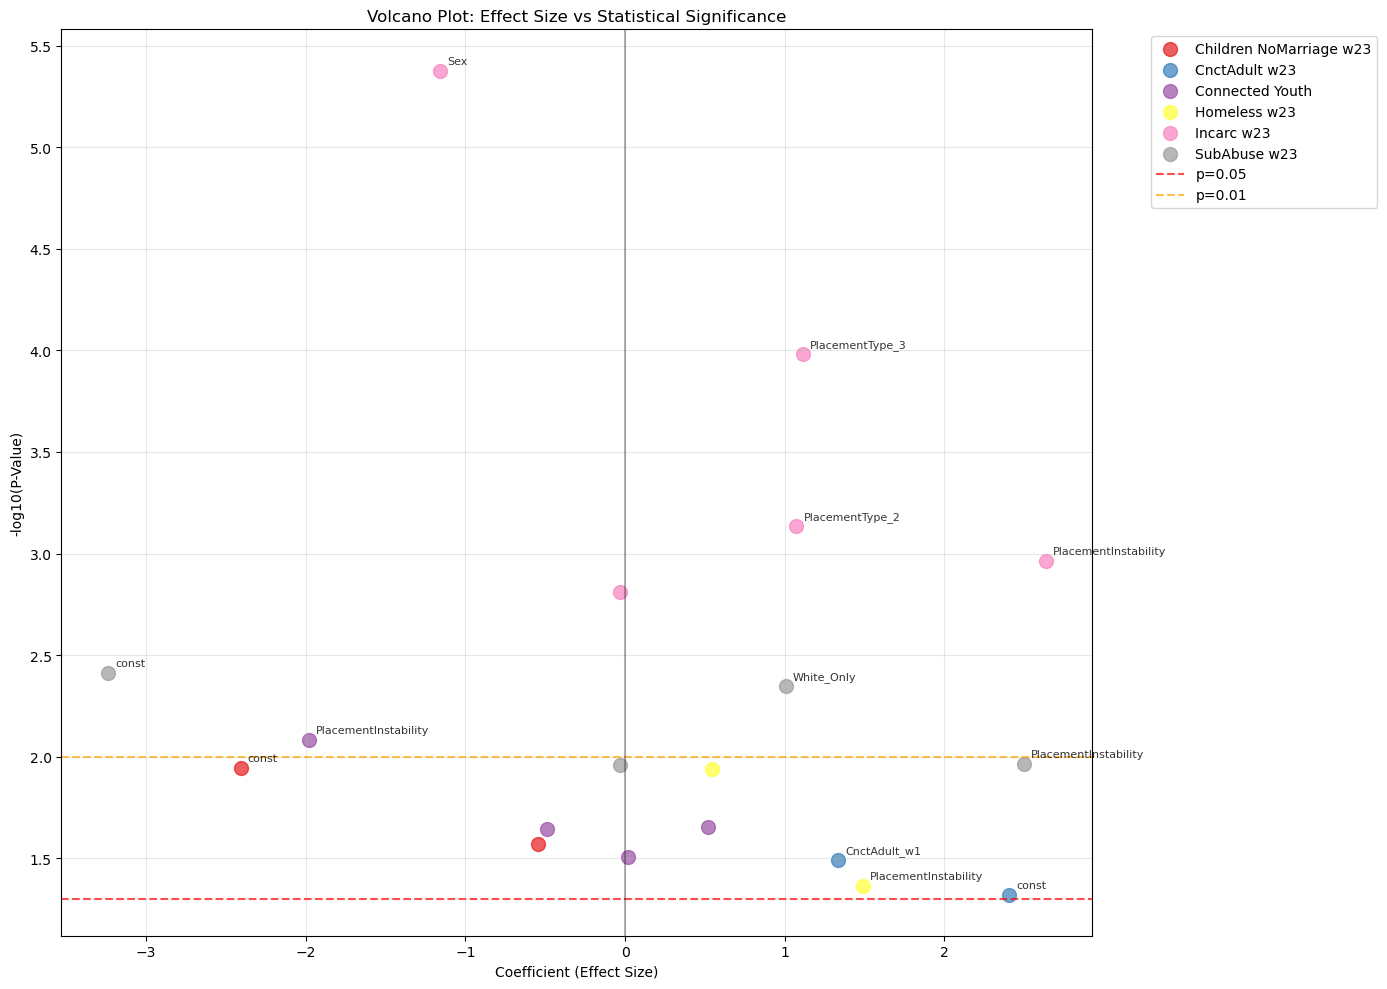

In [50]:
# Cell 7: Volcano Plot - Effect Size vs Significance
plt.figure(figsize=(14, 10))

# Create volcano plot
x = significant_model_results['Coefficient']
y = -np.log10(significant_model_results['P-Value'])

# Color by outcome
outcomes = significant_model_results['Outcome'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(outcomes)))
color_map = dict(zip(outcomes, colors))

for outcome in outcomes:
    mask = significant_model_results['Outcome'] == outcome
    plt.scatter(x[mask], y[mask], 
               label=outcome.replace('_', ' '), 
               alpha=0.7, s=100, 
               color=color_map[outcome])

plt.xlabel('Coefficient (Effect Size)')
plt.ylabel('-log10(P-Value)')
plt.title('Volcano Plot: Effect Size vs Statistical Significance')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
plt.axhline(y=-np.log10(0.01), color='orange', linestyle='--', alpha=0.7, label='p=0.01')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add labels for extreme points
for _, row in significant_model_results.iterrows():
    if abs(row['Coefficient']) > 1 or row['P-Value'] < 0.001:
        plt.annotate(f"{row['Variable']}", 
                    (row['Coefficient'], -np.log10(row['P-Value'])),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.8)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Visual Above: 
 * shows effect size (x-axis) and statistical significance (y-axis) for all significant predictors

**Top Right: High Significance + High risk factor**
* PlacementType_2 & PlacementType_3: increase incarceration risk

**Top Left Quadrant: High significance + Strong protective factor**
* Sex (female):  protects against incarceration

**Moderate Importance: High significnace + Moderate effect**
* White_Only 
* CnctAdult_w1

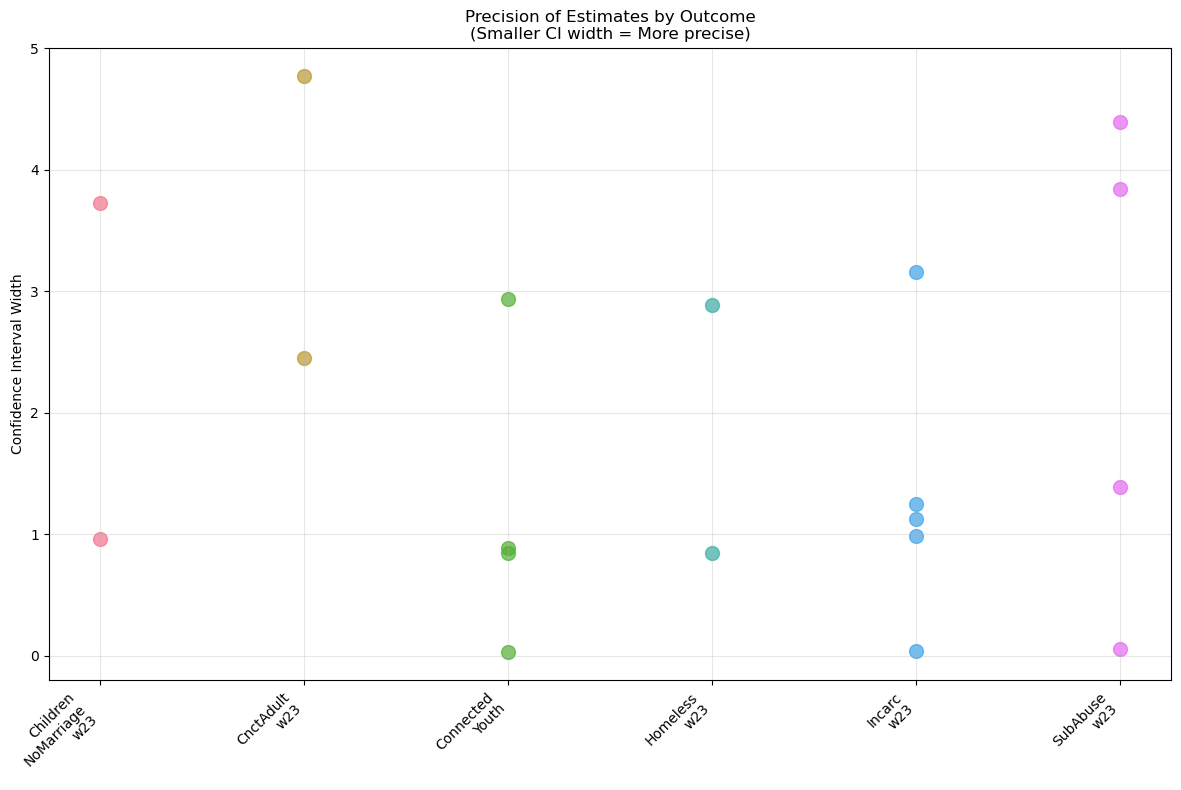

In [51]:
# Cell 8: Confidence Interval Width Analysis
plt.figure(figsize=(12, 8))

# Calculate CI width
significant_model_results['CI_Width'] = (significant_model_results['CI Upper'] - 
                                        significant_model_results['CI Lower'])

# Plot CI width by outcome
outcomes = significant_model_results['Outcome'].unique()
for i, outcome in enumerate(outcomes):
    outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
    plt.scatter([i] * len(outcome_data), outcome_data['CI_Width'], 
               alpha=0.7, s=100, label=outcome)

plt.xticks(range(len(outcomes)), [outcome.replace('_', '\n') for outcome in outcomes], 
           rotation=45, ha='right')
plt.ylabel('Confidence Interval Width')
plt.title('Precision of Estimates by Outcome\n(Smaller CI width = More precise)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Visual above
* statistical precision of your effect estimates across outcomes
* Smaller confidence interval (CI) widths indicate more precise, reliable estimates of the true effect sizes.

**High Precision: CI widths < 1.0**
* Connected Youth
* Homeless w23 
* Incarceration

**Moderate Precision: CI widths 1.0-2.5**
* Children NoMarriage w23
* SubAbuse w23 

**Low Precision: CI widths > 2.5**
* Adult Connections


Variables to explore from main dataset: ['White_Only', 'CnctAdult_w1', 'PlacementInstability', 'Sex', 'DiagDis', 'MonthsInCare']


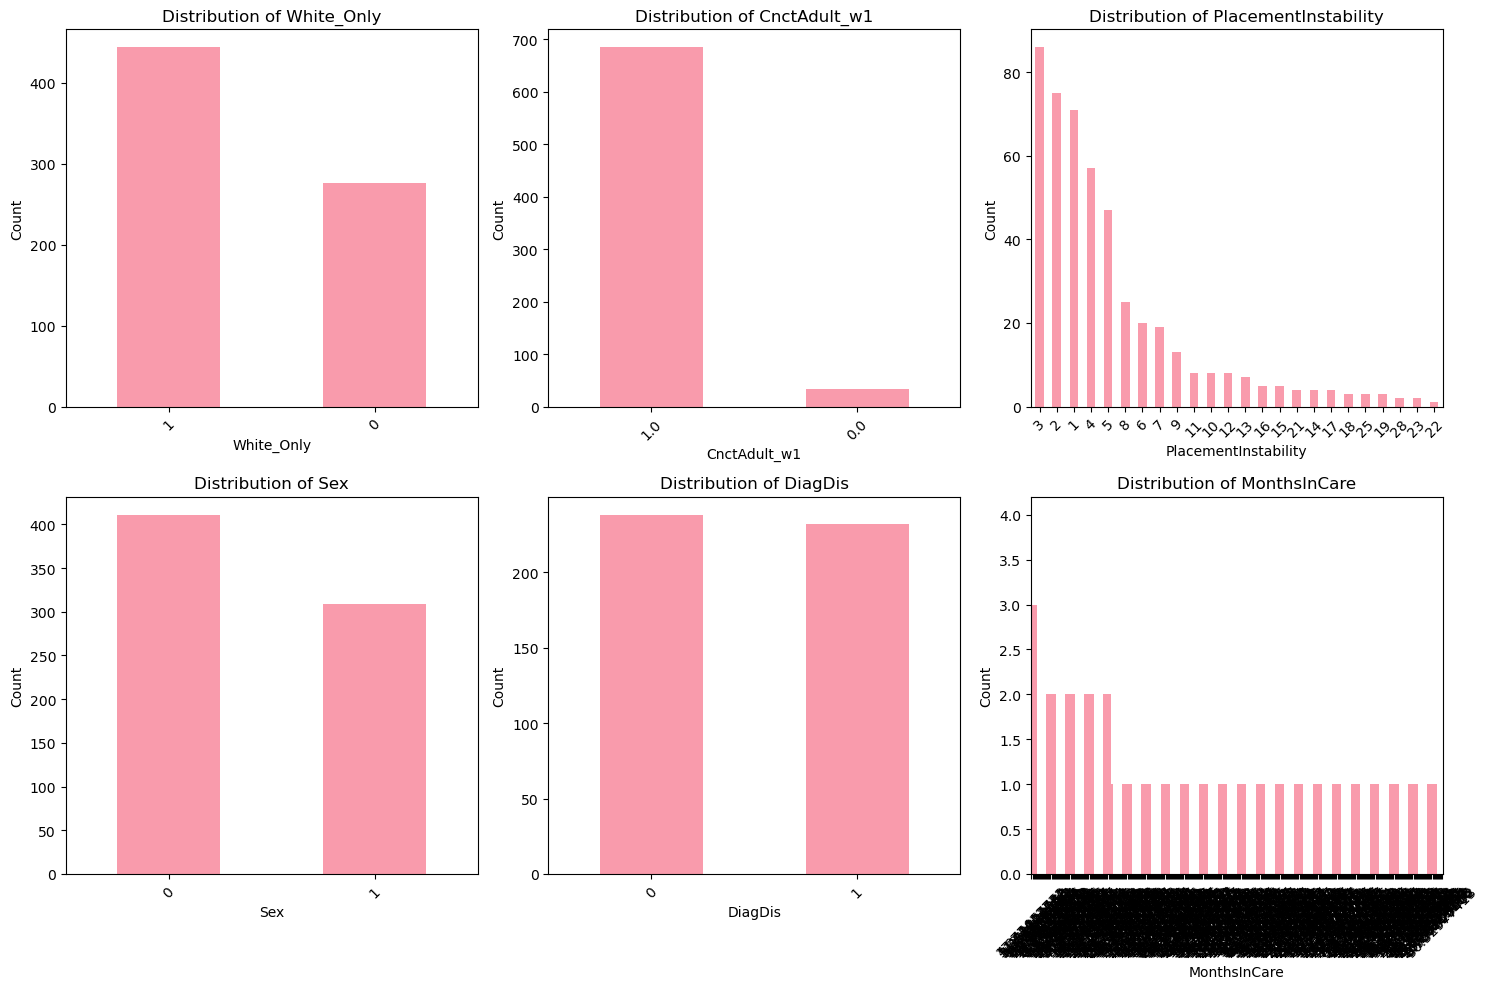

In [52]:
# Cell 9: Data exploration for significant variables in main dataset
# Get unique variables (excluding 'const')
unique_vars = [var for var in significant_model_results['Variable'].unique() if var != 'const']
available_vars = [var for var in unique_vars if var in wave_service_afcars.columns]

print(f"Variables to explore from main dataset: {available_vars}")

if available_vars:
    # Create distribution plots
    n_vars = len(available_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.flatten() if n_vars > 1 else [axes]
    else:
        axes = axes.flatten()
    
    for i, var in enumerate(available_vars):
        if wave_service_afcars[var].dtype in ['int64', 'Int64', 'float64']:
            # Numeric variable
            wave_service_afcars[var].hist(bins=30, alpha=0.7, ax=axes[i], edgecolor='black')
            axes[i].set_title(f'Distribution of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frequency')
        else:
            # Categorical variable
            wave_service_afcars[var].value_counts().plot(kind='bar', ax=axes[i], alpha=0.7)
            axes[i].set_title(f'Distribution of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(len(available_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

### Visuals Above:

**Top left : White_only**
*  ~62% White-only, ~38% other races
* Sufficient representation in both groups for reliable comparisons

**Top Middle: CnctAdult_w1**
* Heavily skewed: ~95% have adult connection, only ~5% have no connection

**Top Right: PlacementInstability**
* Right-skewed distribution: Most youth have 0-2 placement changes
* Long tail: Some youth experience extreme instability (15-20+ changes)
* Typical range: 0-5 changes for most youth

**Bottom Left: Sex**
* 0 = Male, 1 = Female
* Distribution: ~57% male, ~43% female

**Bottom Middle: DiagDis [Diagnossed Disability]**
* Distribution: ~52% no disability, ~48% with disability

**Bottom Right: MonthsInCare**
* Continuous variable: Very wide range (0 to 200+ months)
* Right-skewed: Most youth in care for shorter periods
* Extended tail: Some youth in care for 10+ years
* Typical range: 0-50 months for most youth

In [53]:
# Cell 10: Summary Tables and Key Insights
print("="*80)
print("SUMMARY OF SIGNIFICANT RESULTS")
print("="*80)

print(f"\nTotal significant effects found: {len(significant_model_results)}")
print(f"Outcomes analyzed: {len(significant_model_results['Outcome'].unique())}")
print(f"Unique variables with significant effects: {len(significant_model_results['Variable'].unique())}")

print("\n" + "="*50)
print("STRONGEST EFFECTS (by absolute coefficient)")
print("="*50)
strongest_effects = significant_model_results.reindex(
    significant_model_results['Coefficient'].abs().sort_values(ascending=False).index
).head(5)

for _, row in strongest_effects.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"\n{row['Variable']} → {row['Outcome']}")
    print(f"  Coefficient: {row['Coefficient']:.3f} (p={row['P-Value']:.4f})")
    print(f"  Effect: {row['Variable']} {direction} {row['Outcome']} by {abs(row['Coefficient']):.3f} units")

print("\n" + "="*50)
print("MOST SIGNIFICANT EFFECTS (by p-value)")
print("="*50)
most_significant = significant_model_results.nsmallest(5, 'P-Value')

for _, row in most_significant.iterrows():
    print(f"\n{row['Variable']} → {row['Outcome']} (p={row['P-Value']:.6f})")
    print(f"  Coefficient: {row['Coefficient']:.3f}")
    print(f"  95% CI: [{row['CI Lower']:.3f}, {row['CI Upper']:.3f}]")

print("\n" + "="*50)
print("EFFECTS BY OUTCOME")
print("="*50)
for outcome in significant_model_results['Outcome'].unique():
    outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
    print(f"\n{outcome}: {len(outcome_data)} significant variables")
    for _, row in outcome_data.iterrows():
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"  {direction} {row['Variable']}: {row['Coefficient']:.3f} (p={row['P-Value']:.4f})")

SUMMARY OF SIGNIFICANT RESULTS

Total significant effects found: 19
Outcomes analyzed: 6
Unique variables with significant effects: 9

STRONGEST EFFECTS (by absolute coefficient)

const → SubAbuse_w23
  Coefficient: -3.237 (p=0.0039)
  Effect: const decreases SubAbuse_w23 by 3.237 units

PlacementInstability → Incarc_w23
  Coefficient: 2.634 (p=0.0011)
  Effect: PlacementInstability increases Incarc_w23 by 2.634 units

PlacementInstability → SubAbuse_w23
  Coefficient: 2.498 (p=0.0108)
  Effect: PlacementInstability increases SubAbuse_w23 by 2.498 units

const → Children_NoMarriage_w23
  Coefficient: -2.408 (p=0.0113)
  Effect: const decreases Children_NoMarriage_w23 by 2.408 units

const → CnctAdult_w23
  Coefficient: 2.407 (p=0.0477)
  Effect: const increases CnctAdult_w23 by 2.407 units

MOST SIGNIFICANT EFFECTS (by p-value)

Sex → Incarc_w23 (p=0.000004)
  Coefficient: -1.157
  95% CI: [-1.650, -0.664]

PlacementType_3 → Incarc_w23 (p=0.000104)
  Coefficient: 1.116
  95% CI: [0.553

# Appendix

In [54]:
# Cell 1: Basic frequency breakdown for each outcome
print("="*60)
print("OUTCOME FREQUENCY BREAKDOWN")
print("="*60)

for outcome in outcomes:
    if outcome in wave_service_afcars.columns:
        print(f"\n{outcome}:")
        freq = wave_service_afcars[outcome].value_counts().sort_index()
        print(freq)
        print(f"Total valid responses: {freq.sum()}")
        print(f"Missing values: {wave_service_afcars[outcome].isna().sum()}")
    else:
        print(f"\n{outcome}: Column not found in dataset")


OUTCOME FREQUENCY BREAKDOWN

Children_NoMarriage_w23:
0    550
1    159
Name: Children_NoMarriage_w23, dtype: Int64
Total valid responses: 709
Missing values: 11

CnctAdult_w23:
0     41
1    678
Name: CnctAdult_w23, dtype: int64
Total valid responses: 719
Missing values: 1

Connected_Youth:
0    252
1    464
Name: Connected_Youth, dtype: Int64
Total valid responses: 716
Missing values: 4

Homeless_w23:
0    508
1    211
Name: Homeless_w23, dtype: int64
Total valid responses: 719
Missing values: 1

Incarc_w23:
0    462
1    256
Name: Incarc_w23, dtype: int64
Total valid responses: 718
Missing values: 2

SubAbuse_w23:
0    584
1    133
Name: SubAbuse_w23, dtype: int64
Total valid responses: 717
Missing values: 3


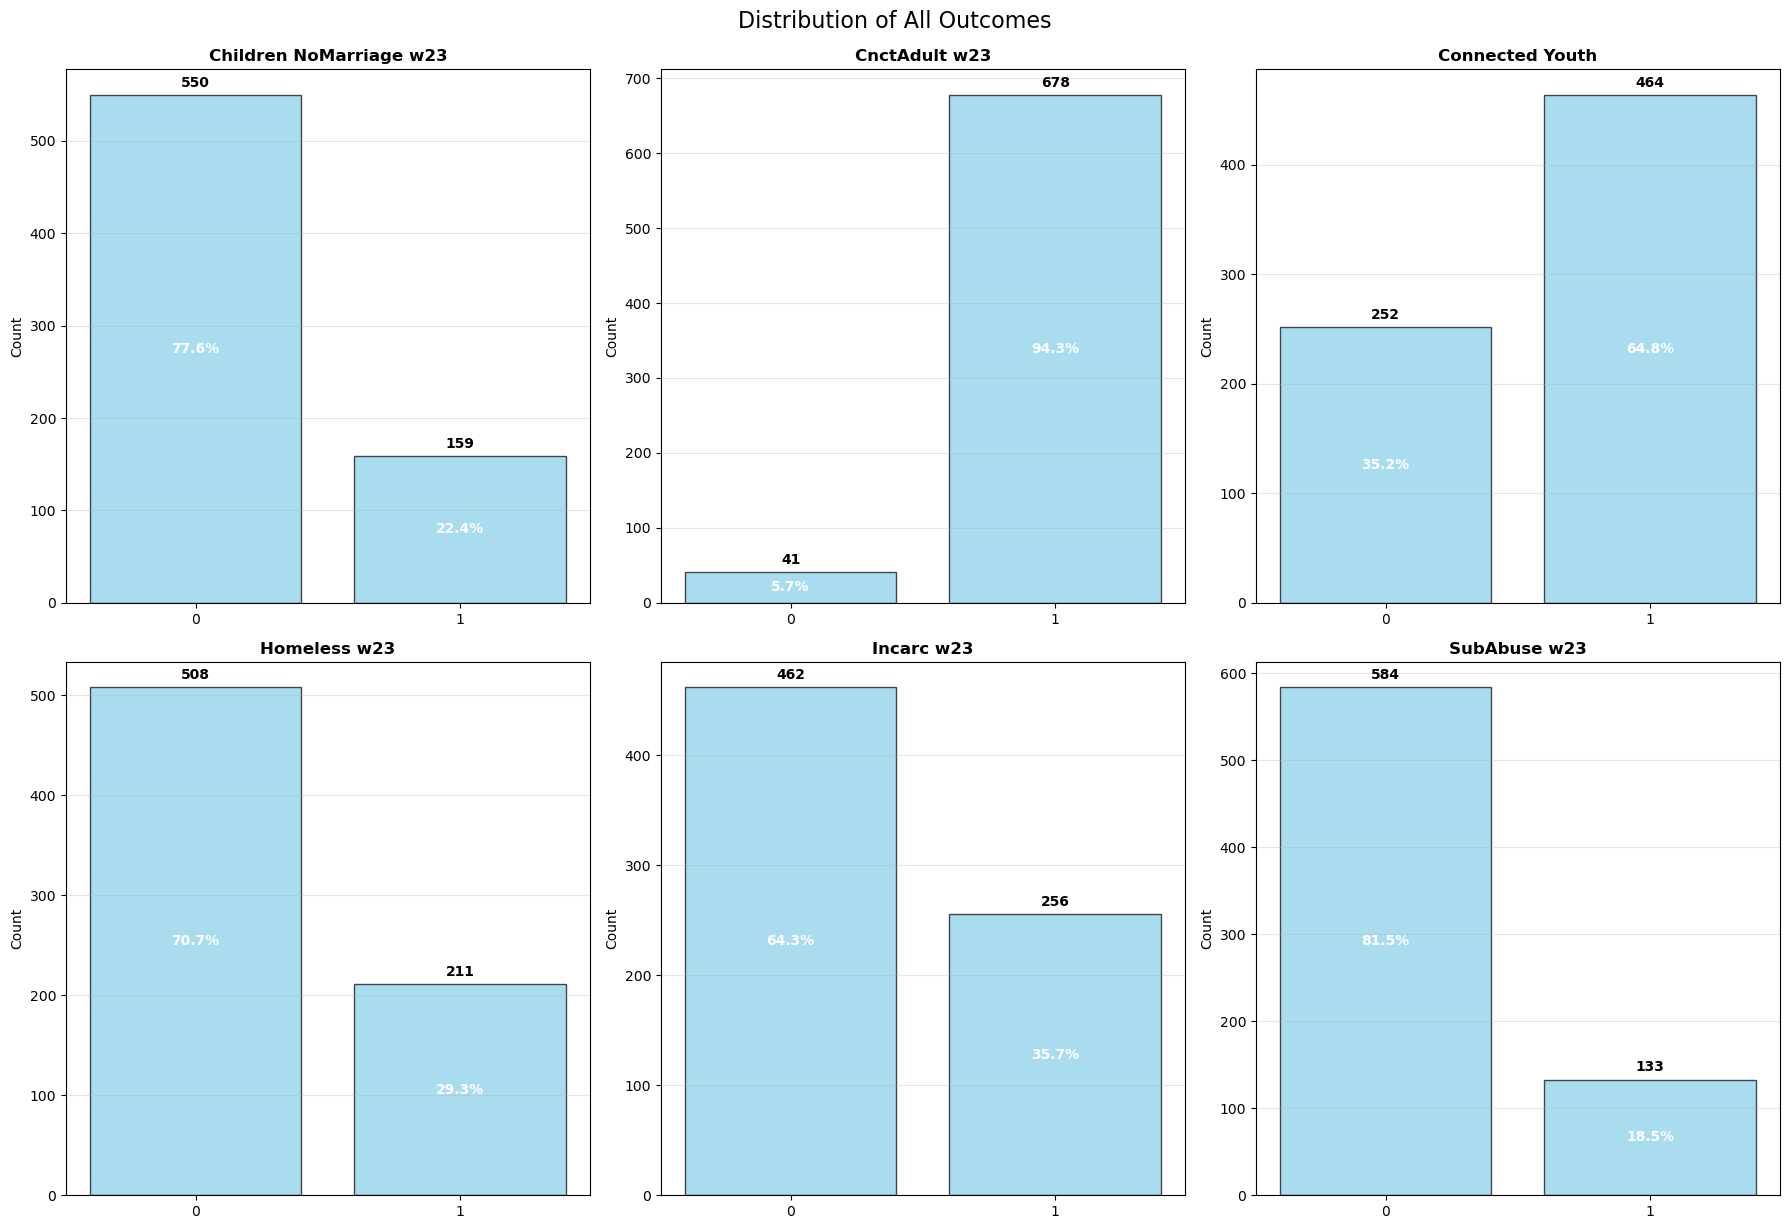

In [55]:
# Cell 2: Bar charts for each outcome separately
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, outcome in enumerate(outcomes):
    if outcome in wave_service_afcars.columns:
        # Get value counts
        counts = wave_service_afcars[outcome].value_counts().sort_index()
        
        # Create bar chart
        axes[i].bar(range(len(counts)), counts.values, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_xticks(range(len(counts)))
        axes[i].set_xticklabels(counts.index)
        axes[i].set_title(f'{outcome.replace("_", " ")}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for j, count in enumerate(counts.values):
            axes[i].text(j, count + max(counts.values) * 0.01, str(count), 
                        ha='center', va='bottom', fontweight='bold')
        
        # Add percentage labels
        total = counts.sum()
        for j, count in enumerate(counts.values):
            pct = (count/total) * 100
            axes[i].text(j, count/2, f'{pct:.1f}%', 
                        ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, f'{outcome}\nNot Found', transform=axes[i].transAxes, 
                    ha='center', va='center', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout()
plt.suptitle('Distribution of All Outcomes', fontsize=16, y=1.02)
plt.show()


BREAKDOWN BY CORE PREDICTORS
Available predictors: ['Sex', 'White_Only', 'race_other']


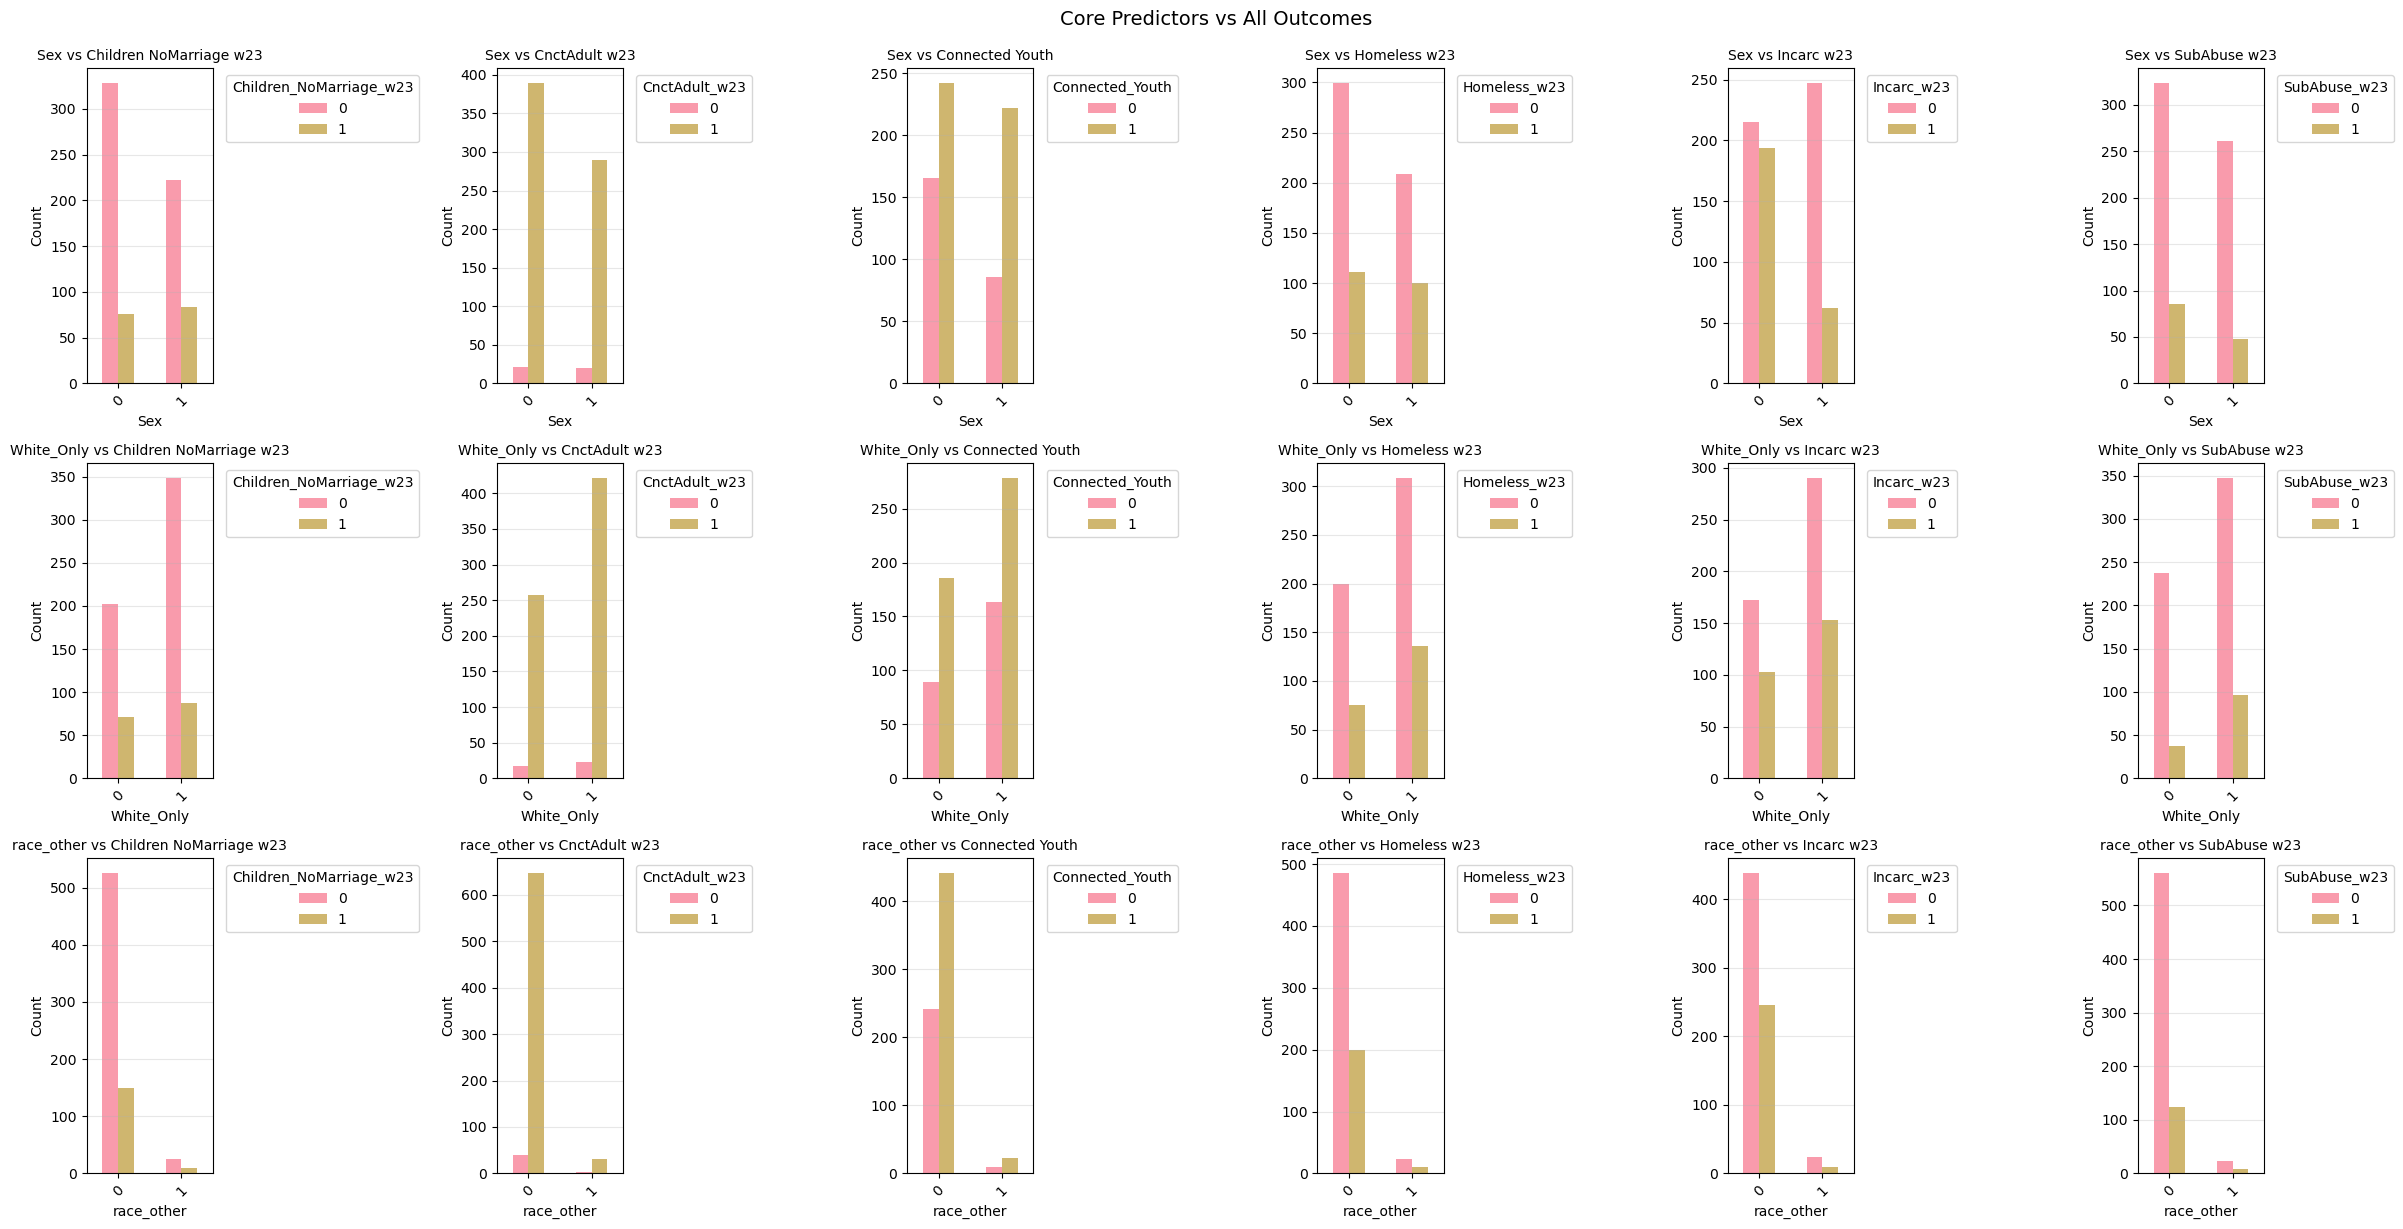


BREAKDOWN BY DISABILITY PREDICTORS
Available predictors: ['DiagDis']


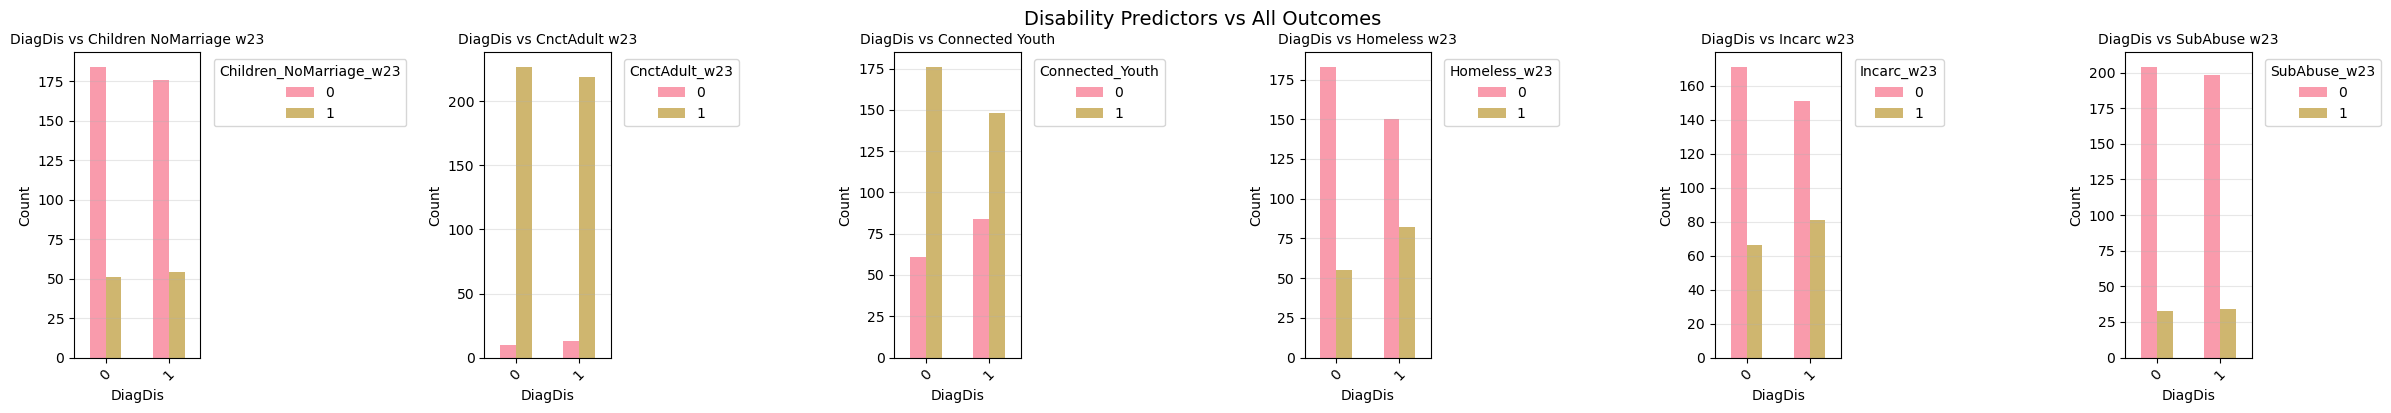


BREAKDOWN BY REMOVALREASON PREDICTORS
Available predictors: ['RR_neglect', 'RR_abuse', 'RR_other']


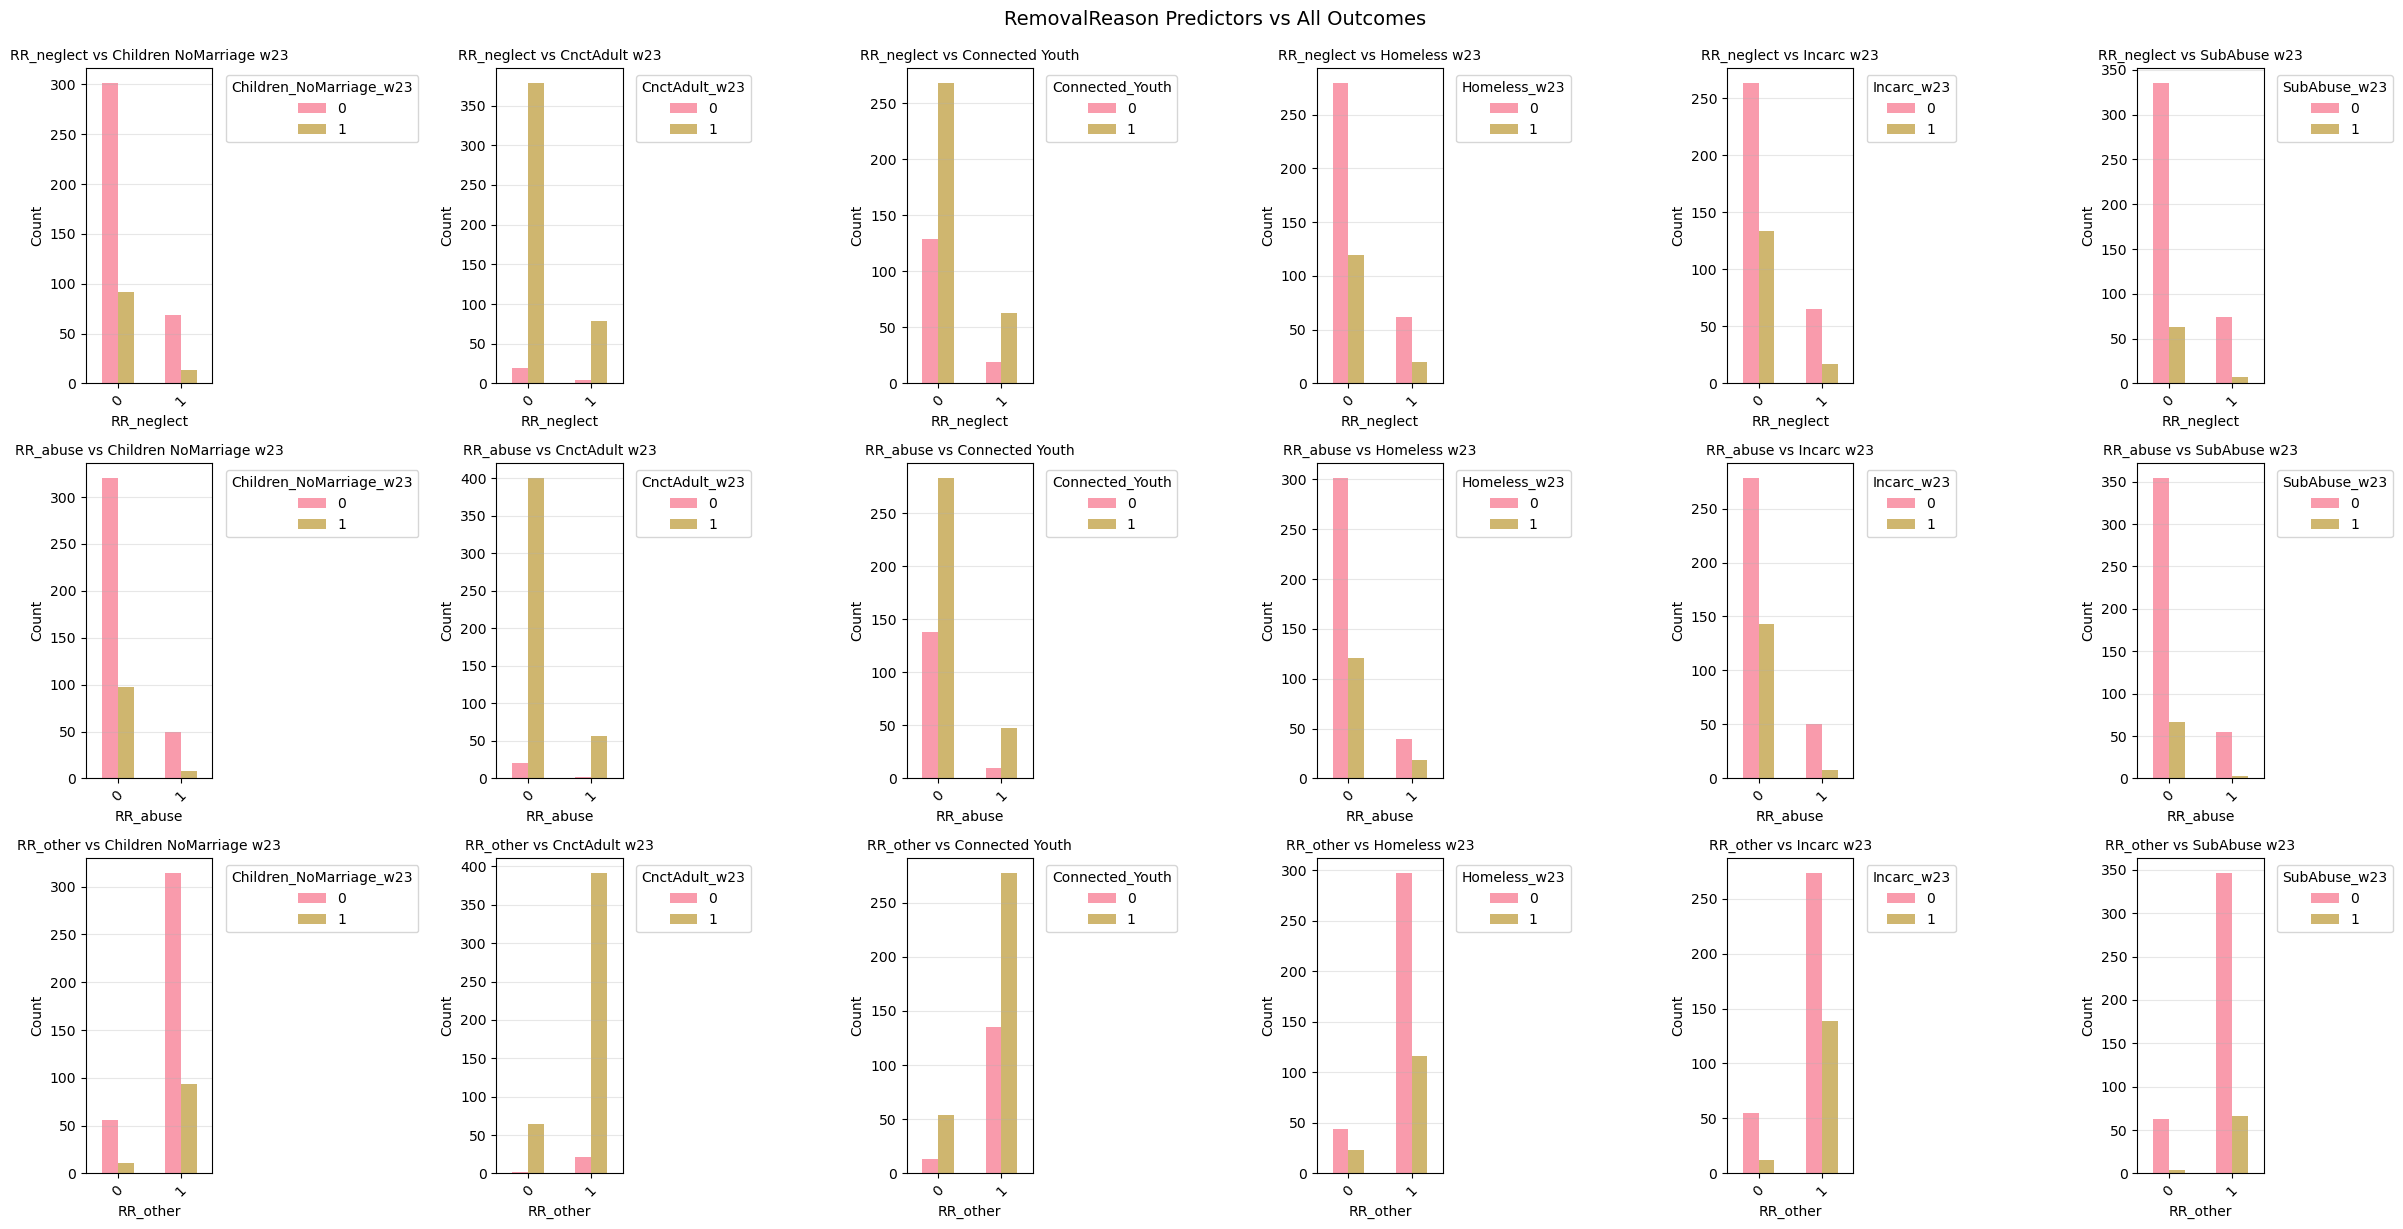


BREAKDOWN BY PLACEMENTOTHER PREDICTORS
Available predictors: ['PlacementType', 'PlacementInstability', 'MonthsInCare']


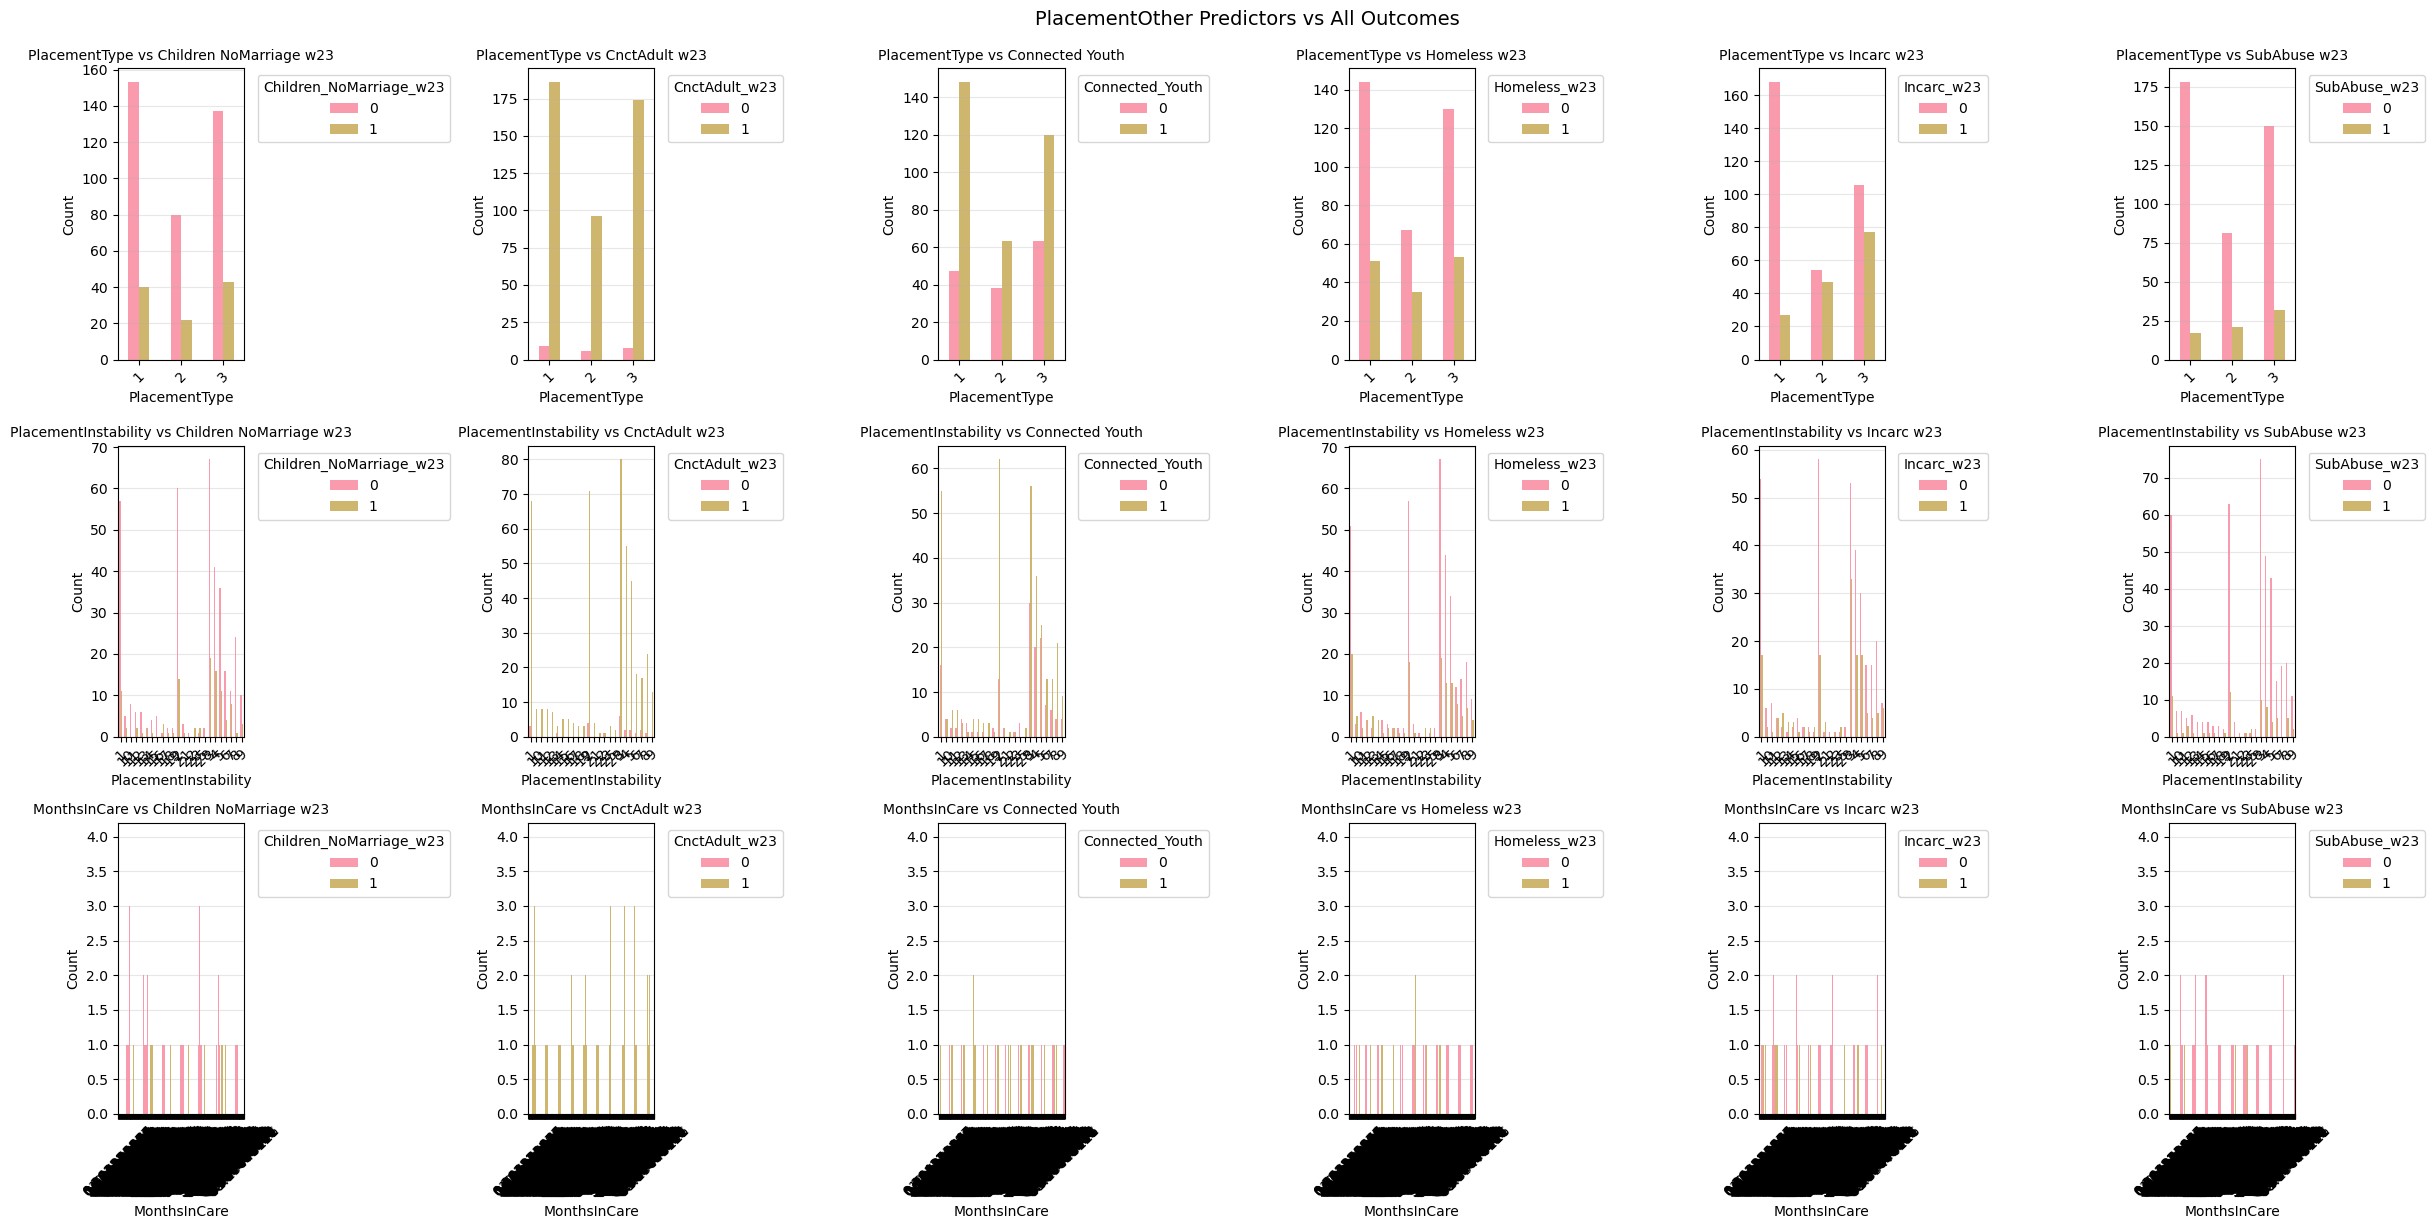


BREAKDOWN BY EARLYINDICATORS PREDICTORS
Available predictors: ['SubAbuse_w1', 'CnctAdult_w1']


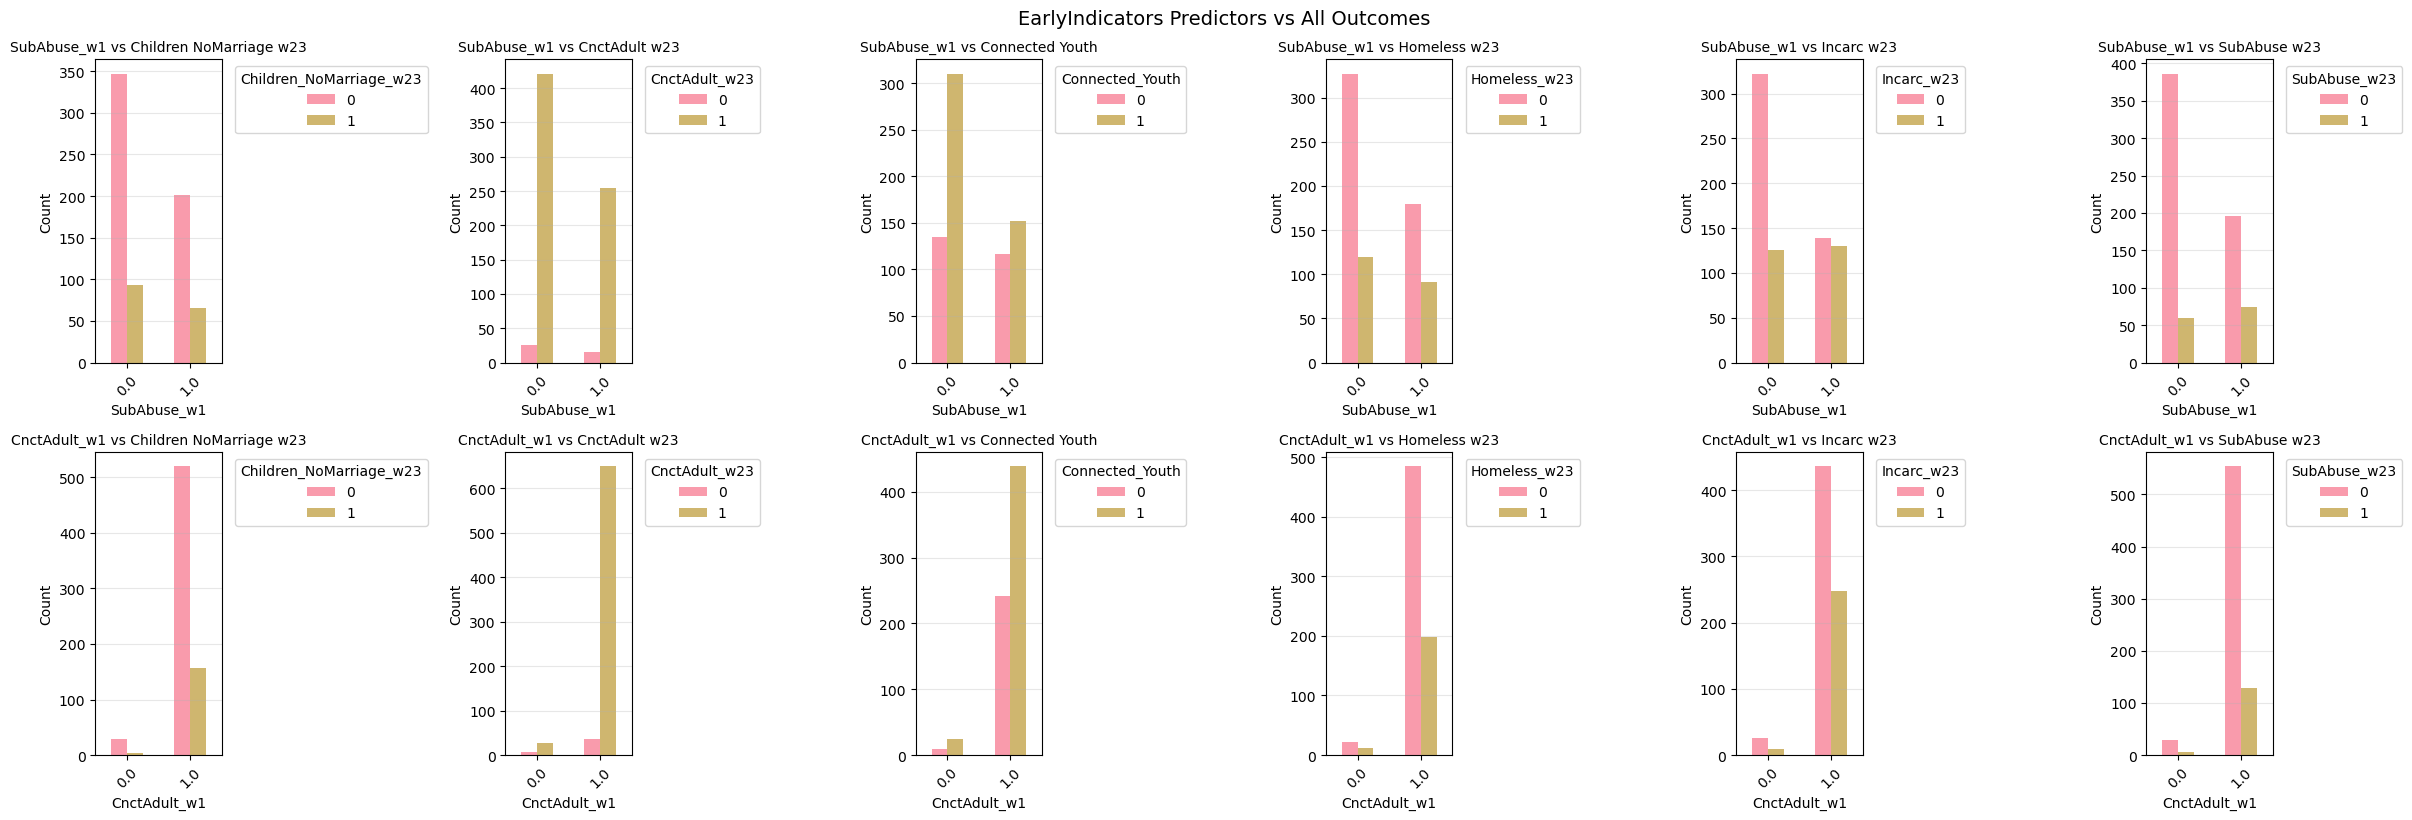

In [56]:

# Cell 3: Breakdown by predictor groups for each outcome
for group_name, predictors in predictor_groups.items():
    print(f"\n{'='*60}")
    print(f"BREAKDOWN BY {group_name.upper()} PREDICTORS")
    print(f"{'='*60}")
    
    # Find available predictors in this group
    available_predictors = [p for p in predictors if p in wave_service_afcars.columns]
    
    if not available_predictors:
        print(f"No predictors from {group_name} group found in dataset")
        continue
    
    print(f"Available predictors: {available_predictors}")
    
    # Create subplots for this predictor group
    n_predictors = len(available_predictors)
    n_outcomes = len([o for o in outcomes if o in wave_service_afcars.columns])
    
    fig, axes = plt.subplots(n_predictors, n_outcomes, figsize=(4*n_outcomes, 4*n_predictors))
    
    if n_predictors == 1:
        axes = axes.reshape(1, -1)
    if n_outcomes == 1:
        axes = axes.reshape(-1, 1)
        
    for pred_idx, predictor in enumerate(available_predictors):
        for out_idx, outcome in enumerate(outcomes):
            if outcome in wave_service_afcars.columns:
                # Create crosstab
                crosstab = pd.crosstab(wave_service_afcars[predictor], 
                                     wave_service_afcars[outcome], 
                                     dropna=False)
                
                # Plot grouped bar chart
                crosstab.plot(kind='bar', ax=axes[pred_idx, out_idx], 
                             alpha=0.7, rot=45)
                axes[pred_idx, out_idx].set_title(f'{predictor} vs {outcome.replace("_", " ")}', 
                                                 fontsize=10)
                axes[pred_idx, out_idx].set_xlabel(predictor)
                axes[pred_idx, out_idx].set_ylabel('Count')
                axes[pred_idx, out_idx].legend(title=outcome, bbox_to_anchor=(1.05, 1), loc='upper left')
                axes[pred_idx, out_idx].grid(True, alpha=0.3, axis='y')
            else:
                axes[pred_idx, out_idx].text(0.5, 0.5, 'Not Available', 
                                           transform=axes[pred_idx, out_idx].transAxes,
                                           ha='center', va='center')
    
    plt.tight_layout()
    plt.suptitle(f'{group_name} Predictors vs All Outcomes', fontsize=14, y=1.02)
    plt.show()


In [57]:
# Cell 4: Summary statistics table for each outcome
print(f"\n{'='*80}")
print("SUMMARY STATISTICS FOR ALL OUTCOMES")
print(f"{'='*80}")

available_outcomes = [o for o in outcomes if o in wave_service_afcars.columns]
if available_outcomes:
    summary_stats = wave_service_afcars[available_outcomes].describe()
    print(summary_stats)
    
    # Calculate additional stats
    print(f"\n{'='*60}")
    print("ADDITIONAL OUTCOME STATISTICS")
    print(f"{'='*60}")
    
    for outcome in available_outcomes:
        data = wave_service_afcars[outcome]
        print(f"\n{outcome}:")
        print(f"  Valid responses: {data.count()}")
        print(f"  Missing values: {data.isna().sum()}")
        print(f"  Missing percentage: {(data.isna().sum()/len(data))*100:.1f}%")
        if data.dtype in ['int64', 'Int64', 'float64']:
            print(f"  Mean: {data.mean():.3f}")
            print(f"  Median: {data.median():.3f}")
            print(f"  Mode: {data.mode().iloc[0] if len(data.mode()) > 0 else 'N/A'}")


SUMMARY STATISTICS FOR ALL OUTCOMES
       Children_NoMarriage_w23  Connected_Youth
count               709.000000       716.000000
mean                  0.224260         0.648045
std                   0.417388         0.477914
min                   0.000000         0.000000
25%                   0.000000         0.000000
50%                   0.000000         1.000000
75%                   0.000000         1.000000
max                   1.000000         1.000000

ADDITIONAL OUTCOME STATISTICS

Children_NoMarriage_w23:
  Valid responses: 709
  Missing values: 11
  Missing percentage: 1.5%
  Mean: 0.224
  Median: 0.000
  Mode: 0

CnctAdult_w23:
  Valid responses: 719
  Missing values: 1
  Missing percentage: 0.1%

Connected_Youth:
  Valid responses: 716
  Missing values: 4
  Missing percentage: 0.6%
  Mean: 0.648
  Median: 1.000
  Mode: 1

Homeless_w23:
  Valid responses: 719
  Missing values: 1
  Missing percentage: 0.1%

Incarc_w23:
  Valid responses: 718
  Missing values: 2
  Missin


DEEP DIVE: CHILDREN_NOMARRIAGE_W23


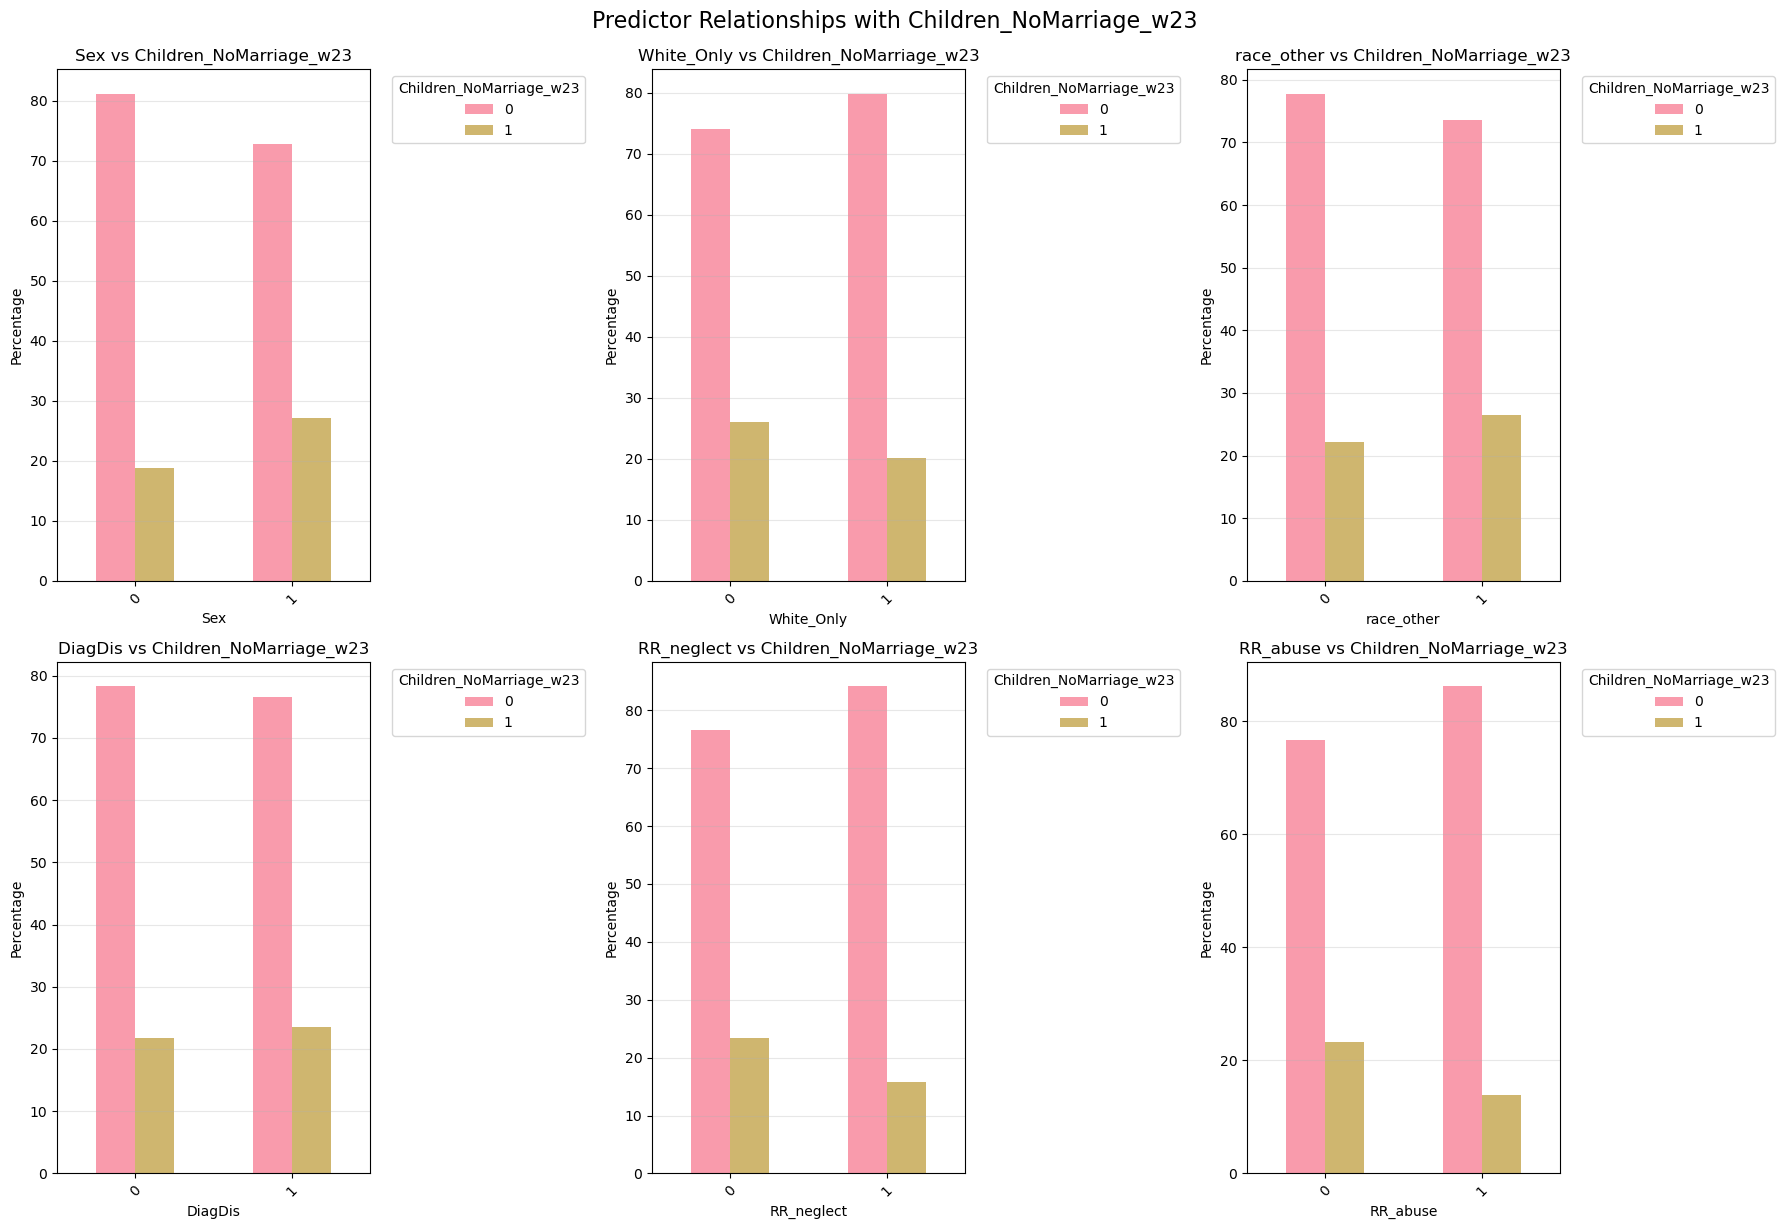


DEEP DIVE: CNCTADULT_W23


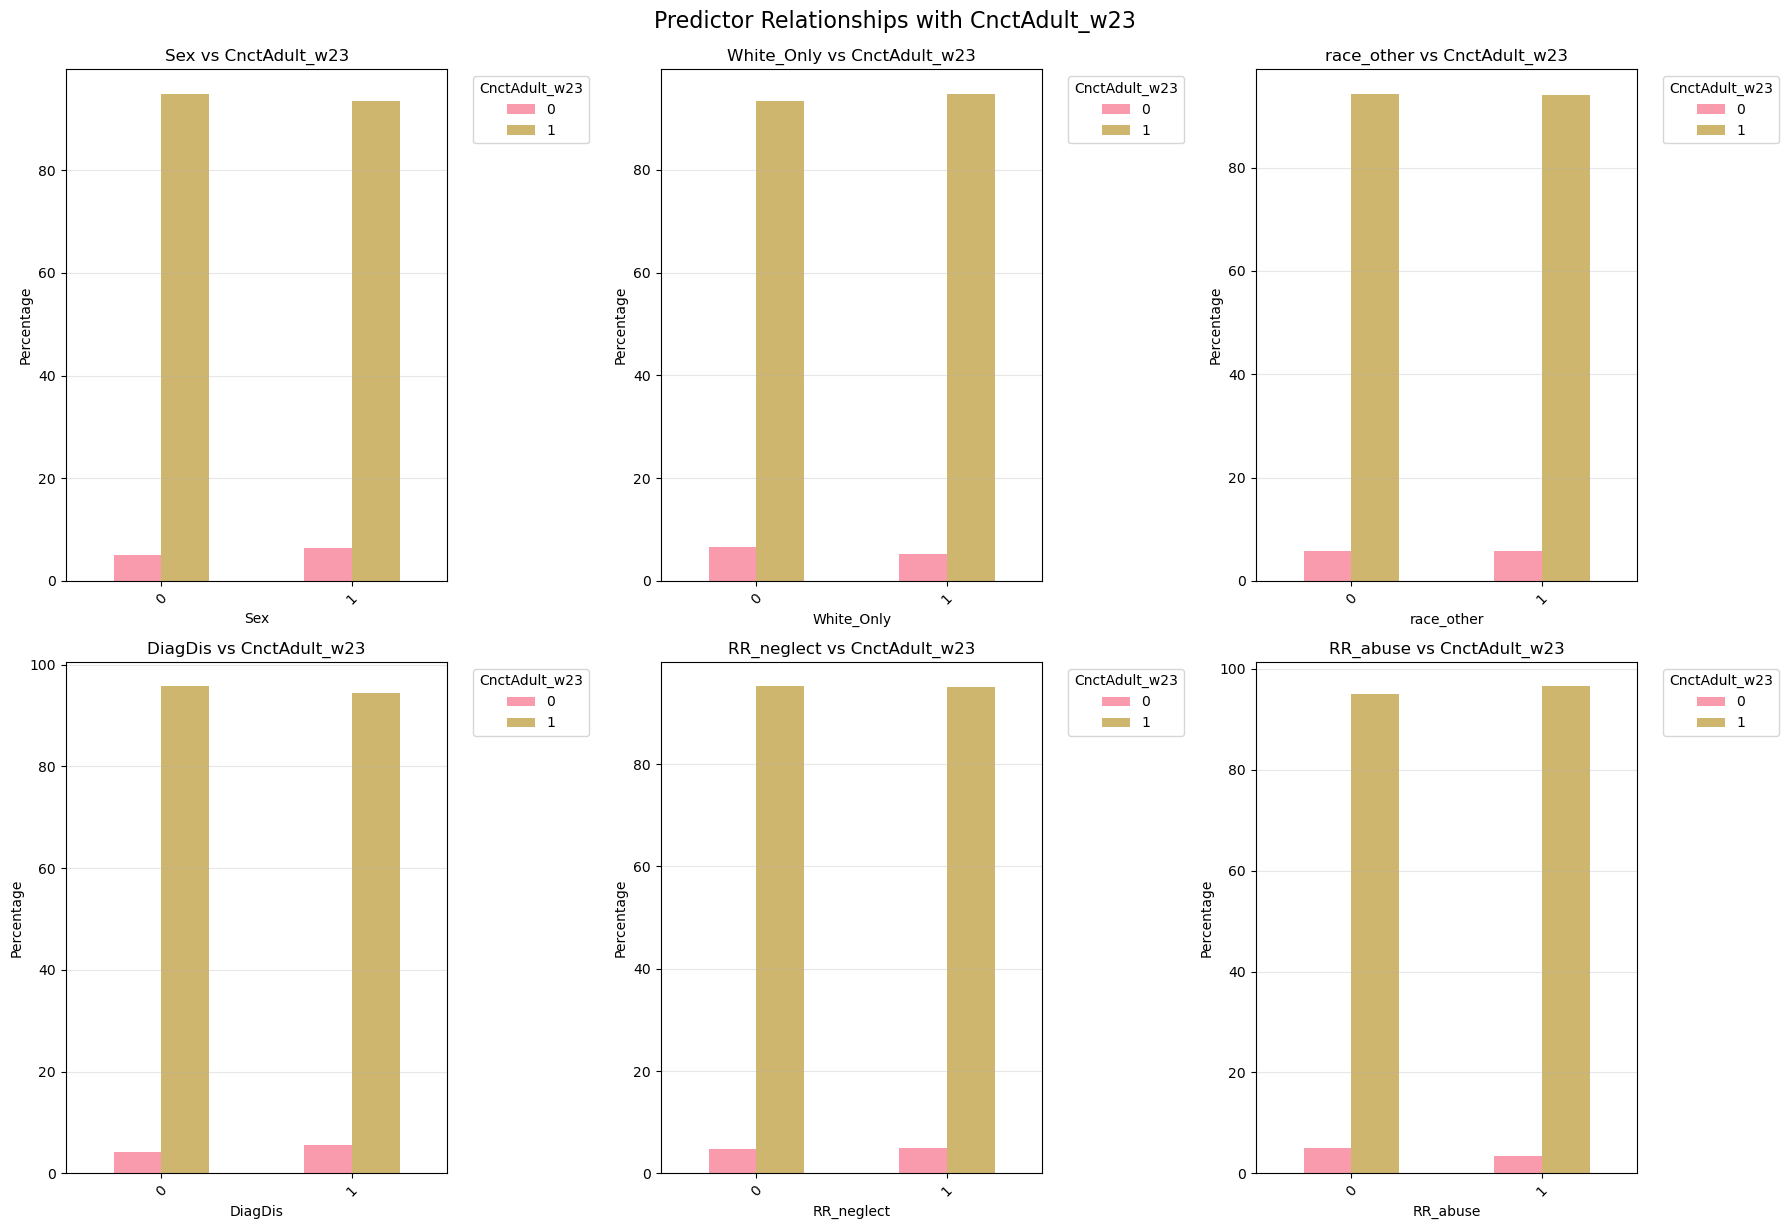


DEEP DIVE: CONNECTED_YOUTH


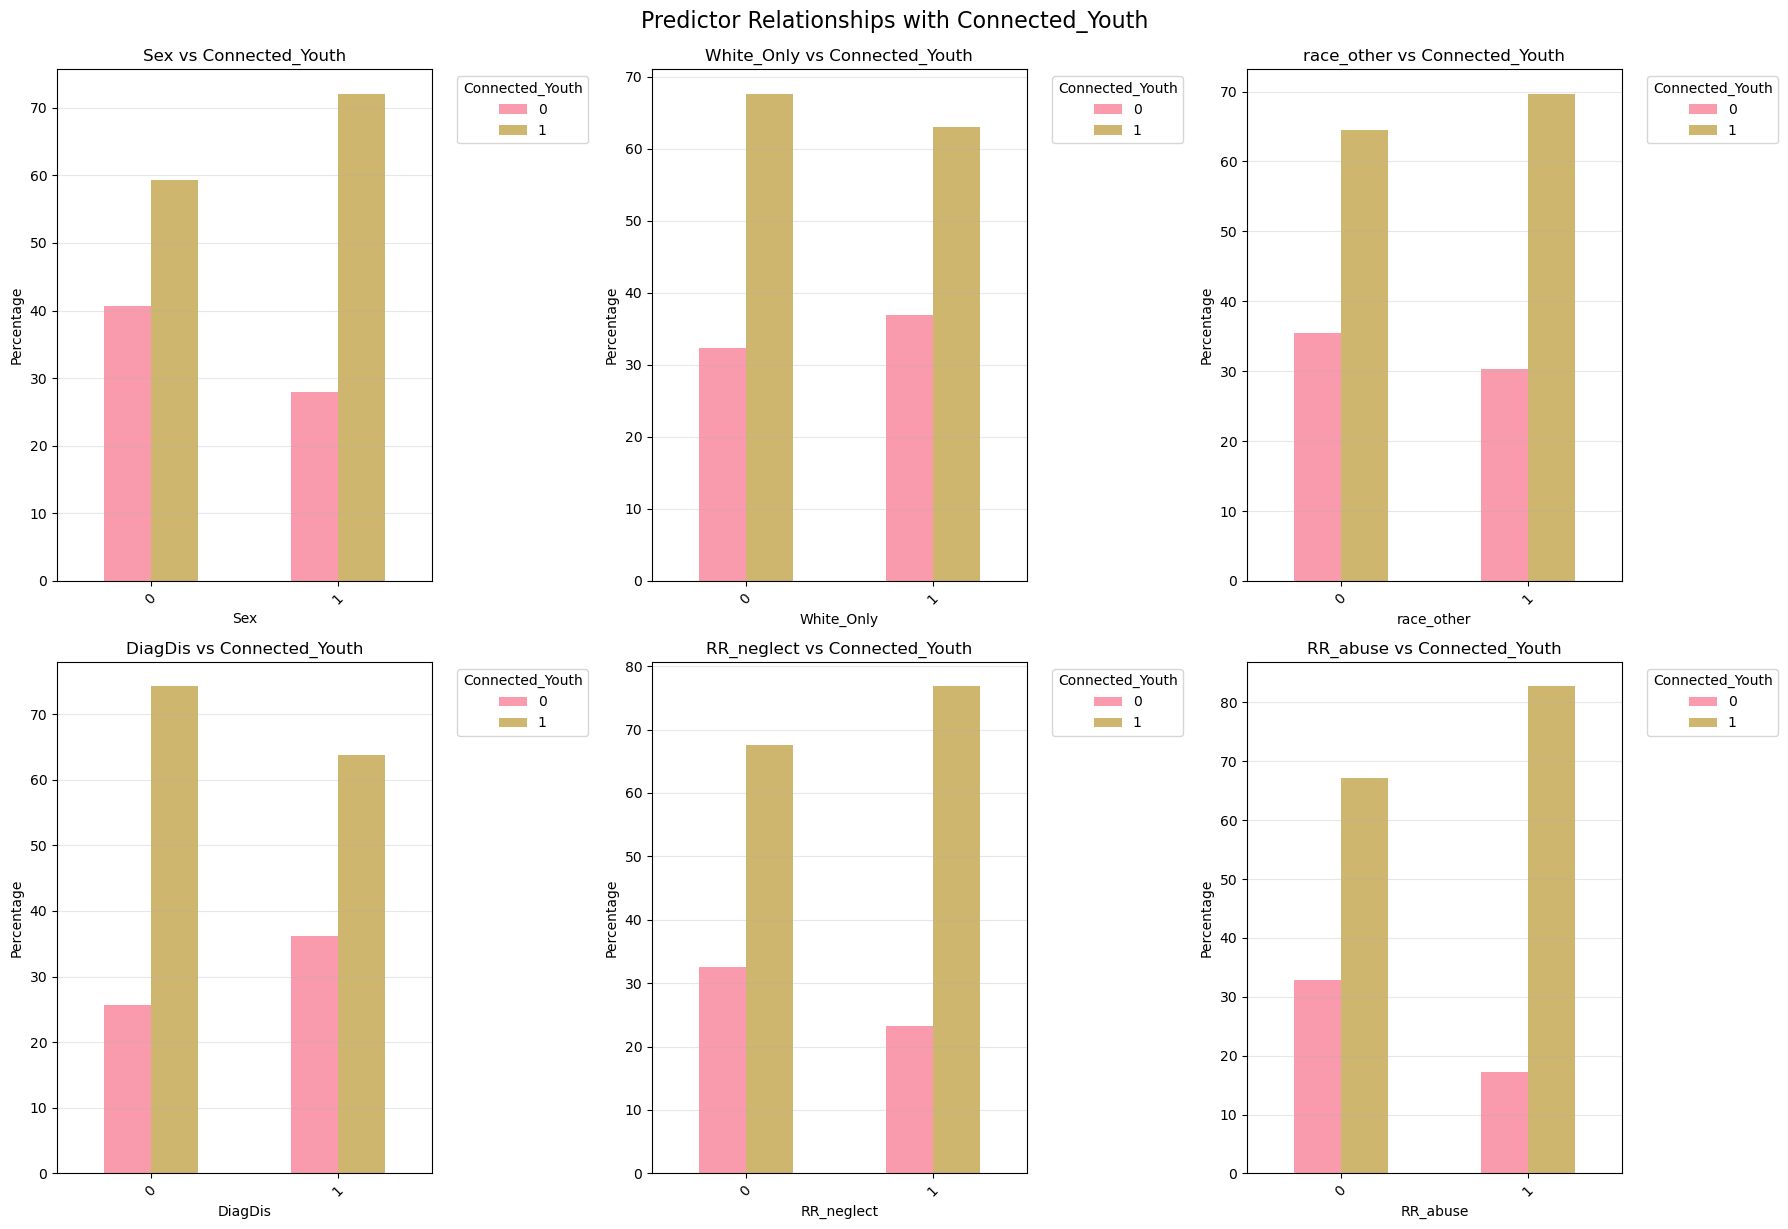


DEEP DIVE: HOMELESS_W23


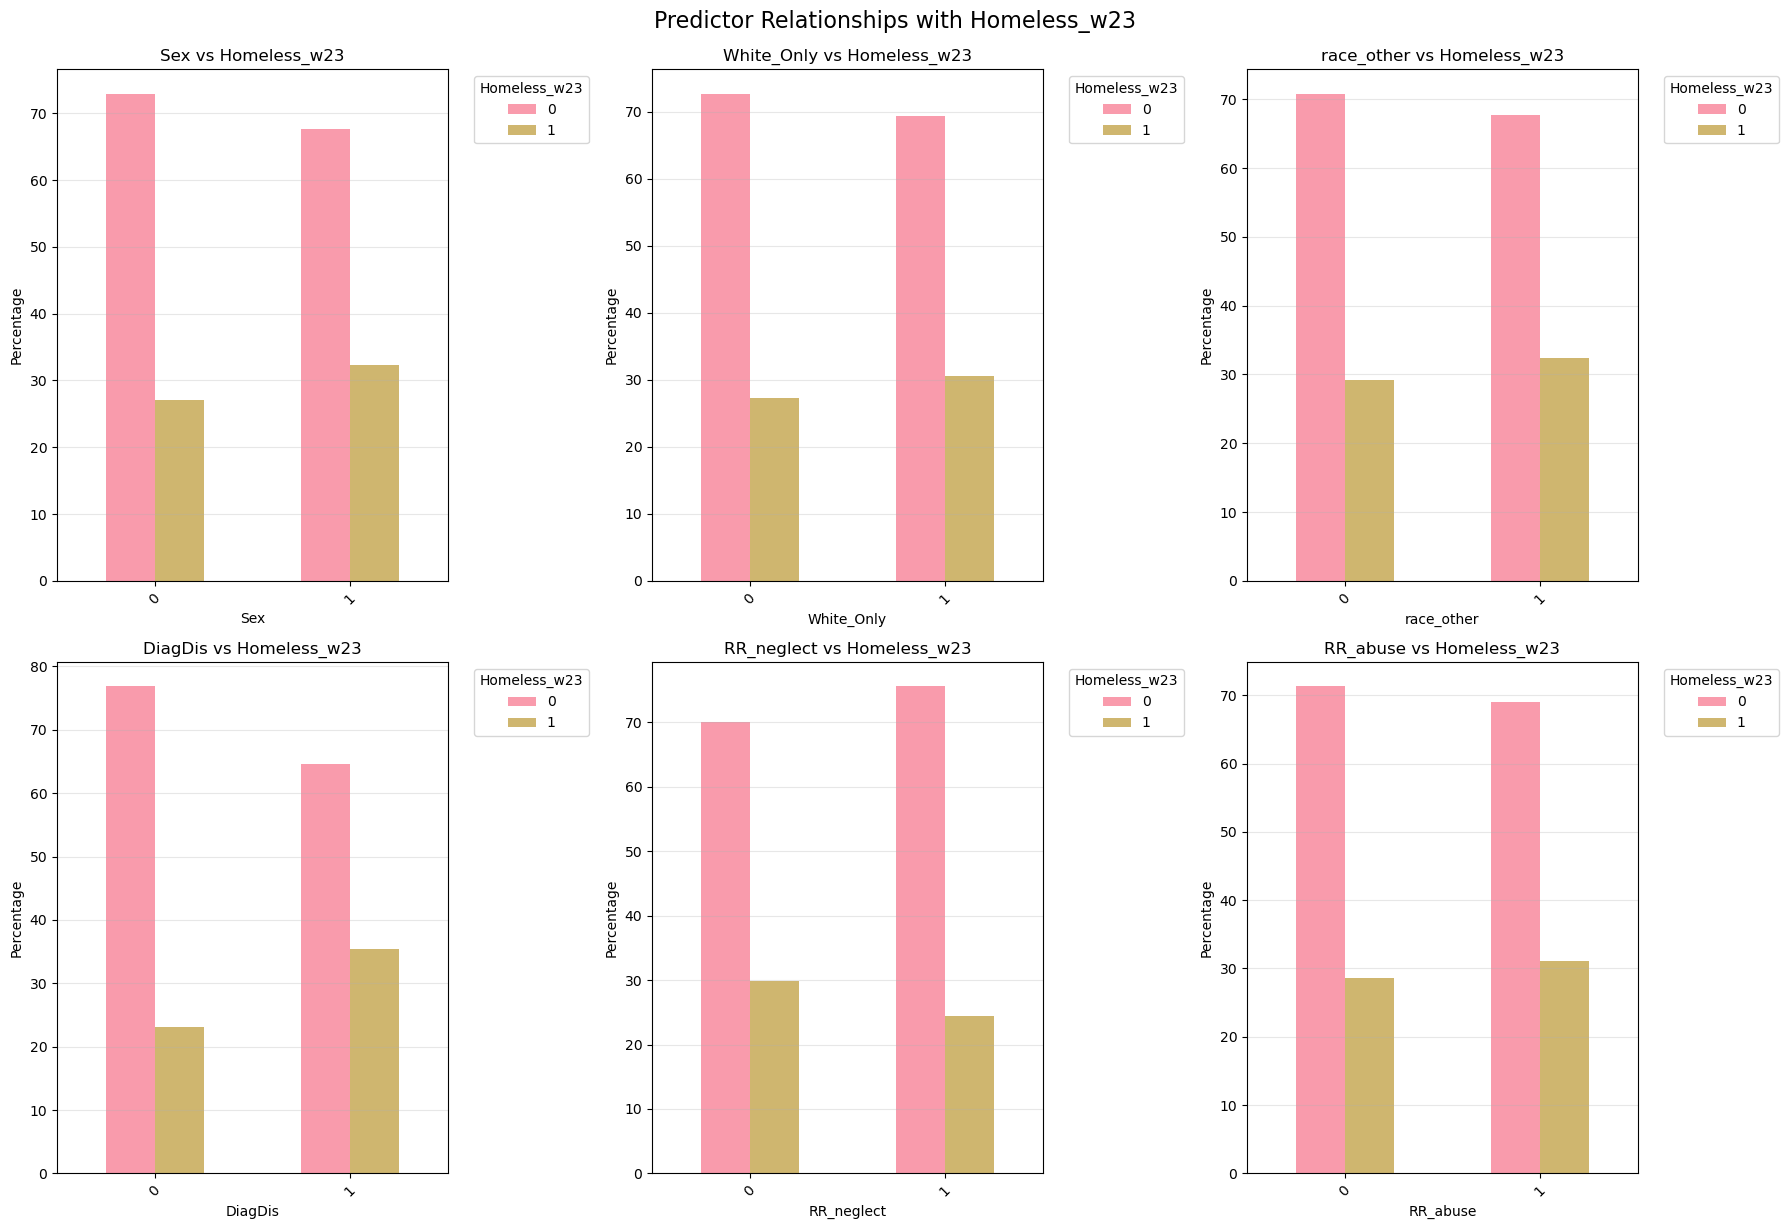


DEEP DIVE: INCARC_W23


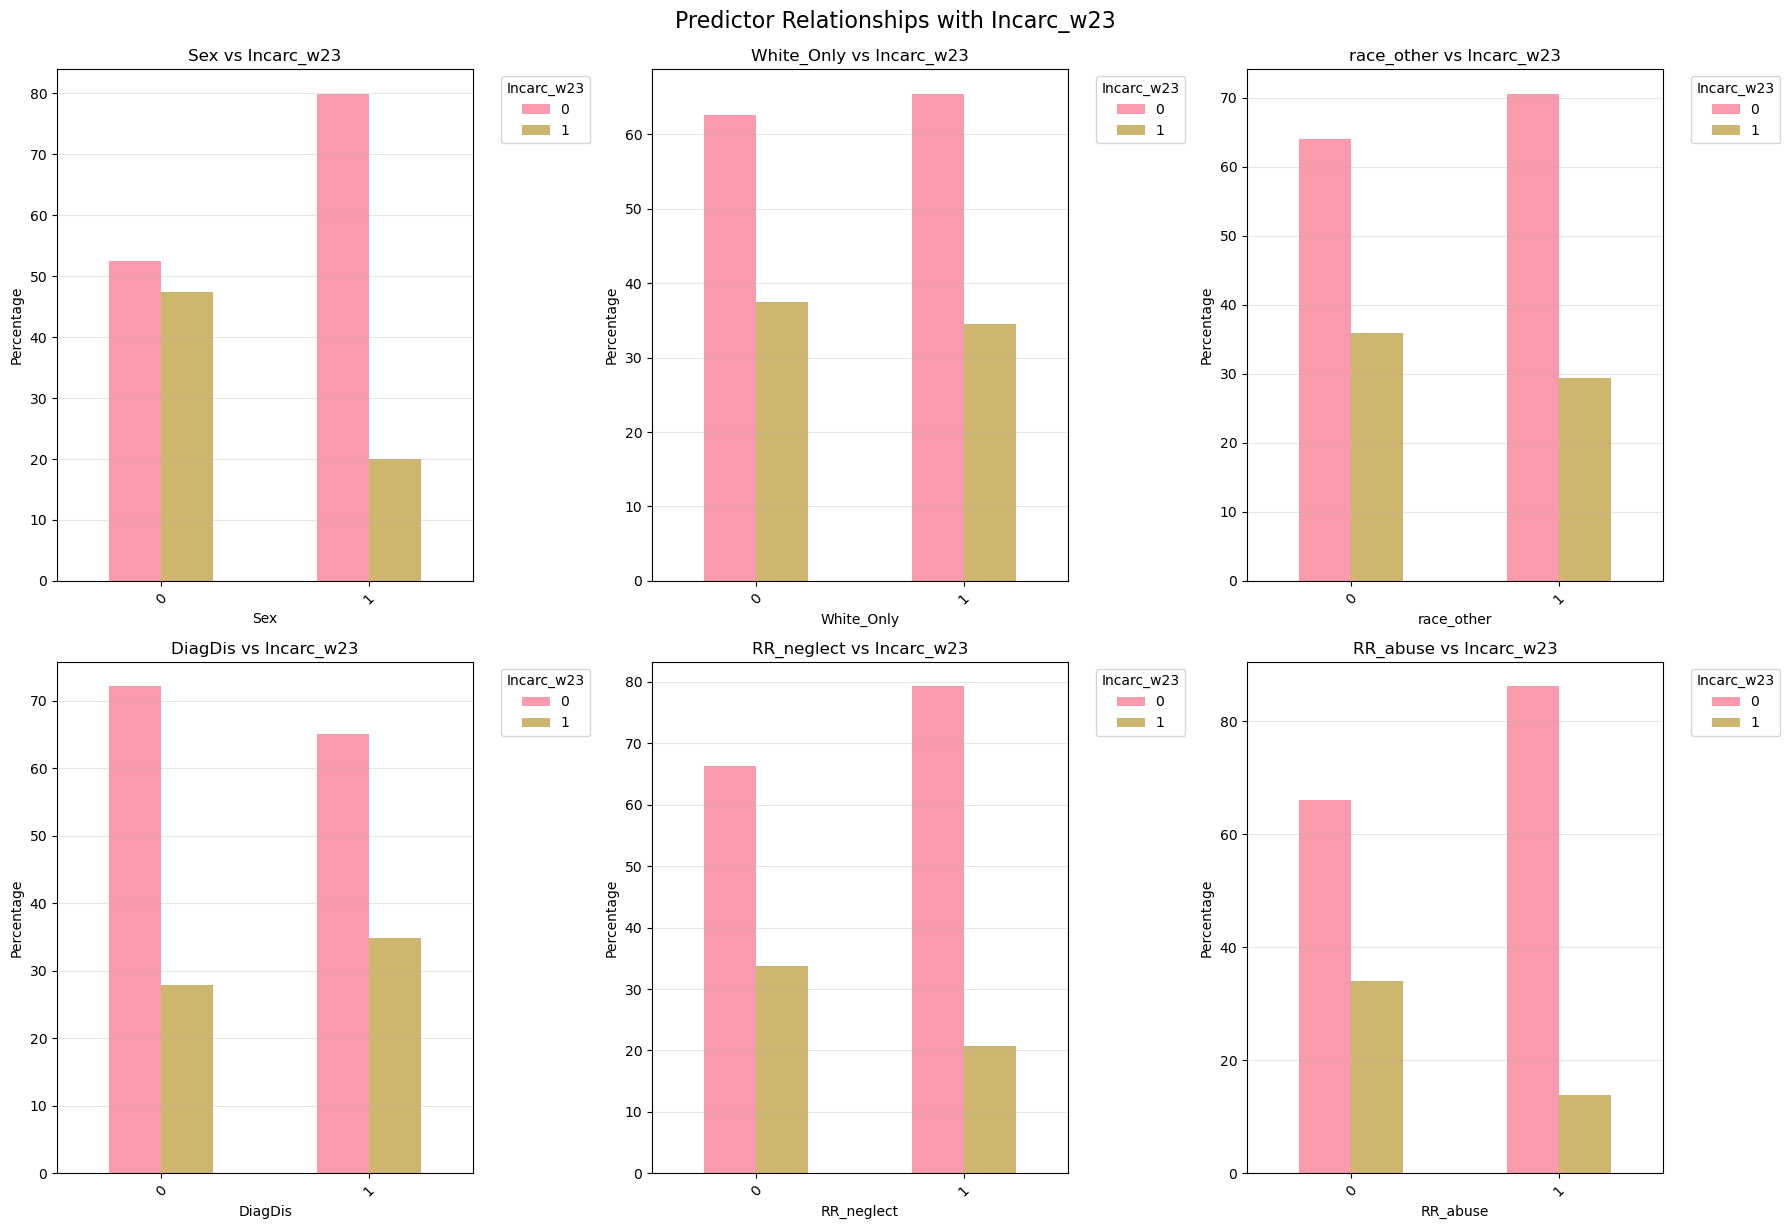


DEEP DIVE: SUBABUSE_W23


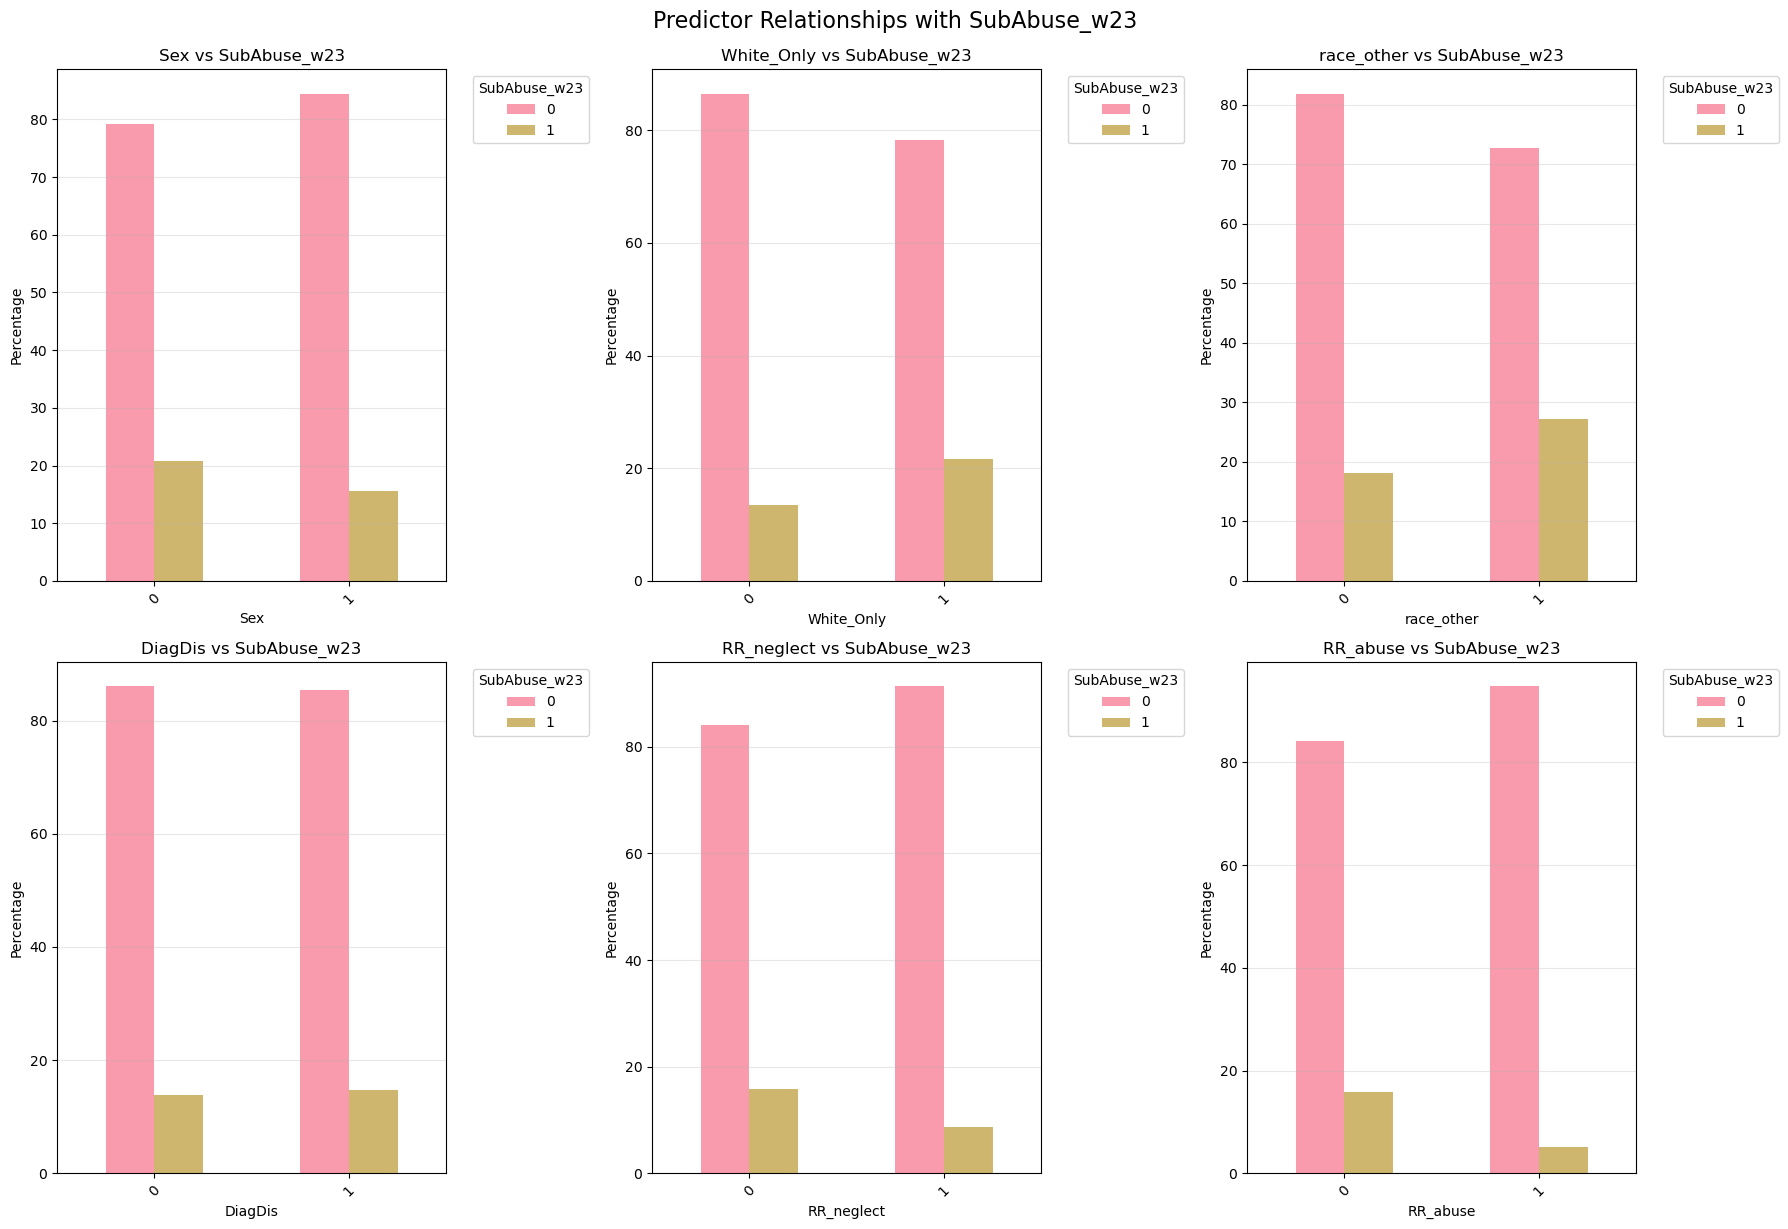

In [58]:
# Cell 6: Individual outcome deep dive charts
for outcome in outcomes:
    if outcome in wave_service_afcars.columns:
        print(f"\n{'='*60}")
        print(f"DEEP DIVE: {outcome.upper()}")
        print(f"{'='*60}")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Get all available predictors
        all_predictors = []
        for group_preds in predictor_groups.values():
            all_predictors.extend(group_preds)
        available_preds = [p for p in all_predictors if p in wave_service_afcars.columns]
        
        # Show top 6 predictors for this outcome
        for i, predictor in enumerate(available_preds[:6]):
            if predictor in wave_service_afcars.columns:
                # Create crosstab
                crosstab = pd.crosstab(wave_service_afcars[predictor], 
                                     wave_service_afcars[outcome], 
                                     normalize='index') * 100  # Convert to percentages
                
                crosstab.plot(kind='bar', ax=axes[i], alpha=0.7, rot=45)
                axes[i].set_title(f'{predictor} vs {outcome}', fontsize=12)
                axes[i].set_xlabel(predictor)
                axes[i].set_ylabel('Percentage')
                axes[i].legend(title=outcome, bbox_to_anchor=(1.05, 1), loc='upper left')
                axes[i].grid(True, alpha=0.3, axis='y')
        
        # Hide empty subplots
        for i in range(len(available_preds), 6):
            if i < 6:
                axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.suptitle(f'Predictor Relationships with {outcome}', fontsize=16, y=1.02)
        plt.show()